In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from numba import njit

In [2]:
df = pd.read_csv("../sample_data/btc_5min_nan_processed_data.csv", parse_dates=["BAR_TIMESTAMP"])

In [3]:
df.head()

,EXCHANGE,SYMBOL,BAR_TIMESTAMP,MARK_PRICE_LAST,INDEX_PRICE_LAST,LAST_PRICE_LAST,OPEN_INTEREST_LAST,FUNDING_RATE_LAST,TICK_COUNT,BUY_LIQUIDATION_VOLUME,...,MIN_TRADE_SIZE,MAX_TRADE_SIZE,TRADE_SIZE_STDDEV,VOLUME_IMBALANCE,TRADE_COUNT_IMBALANCE,LIQ_DURATION,LIQ_LATENCY,TRADE_SPAN,TICK_SPAN,SECONDS_SINCE_FUNDING
0,binance-futures,BTCUSDT,2023-01-01 00:05:00,16521.500000,16527.421047,16521.5,105607.666,0.0001,534.0,0.0,...,0.001,8.458,0.360166,-86.071,-653.0,0.0,231.925,299.872,298.540,-28500.0
1,binance-futures,BTCUSDT,2023-01-01 00:10:00,16517.400000,16522.583810,16517.4,105604.357,0.0001,529.0,0.0,...,0.001,3.766,0.297205,19.624,-367.0,0.0,0.000,299.470,299.065,-28200.0
2,binance-futures,BTCUSDT,2023-01-01 00:15:00,16530.443023,16536.537968,16530.1,105641.237,0.0001,518.0,0.0,...,0.001,5.000,0.412914,68.448,452.0,0.0,142.478,299.206,298.994,-27900.0
3,binance-futures,BTCUSDT,2023-01-01 00:20:00,16531.800000,16536.153333,16531.8,105733.505,0.0001,512.0,0.0,...,0.001,5.057,0.348629,81.538,335.0,0.0,0.000,299.378,299.617,-27600.0
4,binance-futures,BTCUSDT,2023-01-01 00:25:00,16539.661913,16544.077064,16539.3,105796.920,0.0001,500.0,0.0,...,0.001,7.875,0.380222,68.634,535.0,0.0,0.000,299.600,299.589,-27300.0


In [4]:
df['BAR_TIMESTAMP'].aggregate(['min', 'max'])

min   2023-01-01 00:05:00
max   2025-09-30 23:55:00
Name: BAR_TIMESTAMP, dtype: datetime64[ns]

In [5]:
df.shape

(289151, 56)

In [87]:
df.isna().sum().sum()

np.int64(0)

In [88]:
df.columns.to_list()

['EXCHANGE',
 'SYMBOL',
 'BAR_TIMESTAMP',
 'MARK_PRICE_LAST',
 'INDEX_PRICE_LAST',
 'LAST_PRICE_LAST',
 'OPEN_INTEREST_LAST',
 'FUNDING_RATE_LAST',
 'TICK_COUNT',
 'BUY_LIQUIDATION_VOLUME',
 'SELL_LIQUIDATION_VOLUME',
 'TOTAL_LIQUIDATION_VOLUME',
 'BUY_LIQUIDATION_COUNT',
 'SELL_LIQUIDATION_COUNT',
 'TOTAL_LIQUIDATION_COUNT',
 'BUY_LIQUIDATION_NOTIONAL',
 'SELL_LIQUIDATION_NOTIONAL',
 'TOTAL_LIQUIDATION_NOTIONAL',
 'AVG_BUY_LIQUIDATION_SIZE',
 'AVG_SELL_LIQUIDATION_SIZE',
 'AVG_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
 'MIN_LIQUIDATION_PRICE',
 'MAX_LIQUIDATION_PRICE',
 'AVG_LIQUIDATION_PRICE',
 'VWAP_LIQUIDATION_PRICE',
 'LIQUIDATION_VOLUME_IMBALANCE',
 'LIQUIDATION_COUNT_IMBALANCE',
 'OPEN_PRICE',
 'HIGH_PRICE',
 'LOW_PRICE',
 'CLOSE_PRICE',
 'VOLUME',
 'BUY_VOLUME',
 'SELL_VOLUME',
 'BUY_TRADES_COUNT',
 'SELL_TRADES_COUNT',
 'TOTAL_TRADES_COUNT',
 'NOTIONAL_VOLUME',
 'BUY_NOTIONAL',
 'SELL_NOTIONAL',
 'VWAP',
 'AVG_PRICE',
 'PRICE_STDDEV

# A. TARGET GENERATION 


 Triple barrier method + long only + short only = 3 targets 

In [95]:
df['CLOSE_PRICE'].head()

0    16521.5
1    16517.4
2    16530.1
3    16531.8
4    16539.4
Name: CLOSE_PRICE, dtype: float64

In [8]:
import pandas as pd
import numpy as np
from numba import njit

# ==========================================
# 1. THE NUMBA ENGINE (Triple Barrier)
# ==========================================
@njit
def _triple_barrier_kernel(price_values, vol_values, width, expiry):
    n = len(price_values)
    out = np.zeros(n, dtype=np.int8) 

    for t in range(n - expiry):
        v_t = vol_values[t]
        if np.isnan(v_t) or v_t == 0: continue
            
        p_t = price_values[t]
        # Barrier distance based on volatility
        barrier_dist = p_t * v_t * width
        upper = p_t + barrier_dist
        lower = p_t - barrier_dist
        
        for i in range(1, expiry + 1):
            p_future = price_values[t + i]
            hit_up = p_future >= upper
            hit_down = p_future <= lower
            
            if hit_up and hit_down:
                out[t] = -1 # Touched both (whipsaw), mark as fail or side
                break
            elif hit_up:
                out[t] = 1
                break
            elif hit_down:
                out[t] = -1
                break
    return out

# ==========================================
# 2. WRAPPER FUNCTIONS
# ==========================================

def get_triple_barrier_label(price_series, vol_series, width, expiry, mode='both'):
    """
    Standard Triple Barrier Method (Fixed Width * Volatility).
    SCALING ADDED: We now scale vol by sqrt(expiry) so 'width=1.0' means
    '1 standard deviation over the holding period'.
    """
    p_arr = price_series.to_numpy().astype(np.float64)
    v_arr = vol_series.to_numpy().astype(np.float64)
    
    # --- LOGIC FIX: SCALE VOLATILITY ---
    # We want the barrier to represent the expected range over the 'expiry' period.
    # If we don't scale, the barrier is too tight (1-bar width).
    v_scaled = v_arr * np.sqrt(expiry)
    
    # Pass the SCALED volatility to the kernel
    labels_arr = _triple_barrier_kernel(p_arr, v_scaled, width, expiry)
    return pd.Series(labels_arr, index=price_series.index)

def get_dynamic_buy_hold_label(price_series, vol_series, expiry, mode, sigma_mult=0.5):
    """
    Dynamic Buy/Hold Label.
    Threshold adjusts automatically based on market volatility.
    Target = Current Vol * sqrt(Time) * Sigma_Multiplier
    """
    p_arr = price_series.to_numpy().astype(np.float64)
    v_arr = vol_series.to_numpy().astype(np.float64)
    
    # Calculate future price (vectorized)
    future_price = np.full_like(p_arr, np.nan)
    future_price[:-expiry] = p_arr[expiry:]
    
    # Calculate Return
    with np.errstate(divide='ignore', invalid='ignore'):
        ret = (future_price - p_arr) / p_arr
    ret = np.nan_to_num(ret, nan=0.0)
    
    # Calculate Dynamic Threshold
    # We scale 1-period vol by sqrt(expiry) to estimate vol over the holding period
    period_vol = v_arr * np.sqrt(expiry)
    dynamic_threshold = period_vol * sigma_mult
    
    # Generate Labels
    if mode == 'long':
        labels = np.where(ret > dynamic_threshold, 1, 0)
    elif mode == 'short':
        labels = np.where(ret < -dynamic_threshold, 1, 0)
    else:
        labels = np.zeros(len(p_arr), dtype=int)
        
    return pd.Series(labels, index=price_series.index)

# ==========================================
# 3. GENERATE TARGETS & STATISTICS
# ==========================================
def generate_targets(df, price_col='CLOSE_PRICE'):
    print(f"--- Extracting columns for processing ---")
    
    # Ensure we are working with a copy to avoid SettingWithCopy warnings
    cols_to_keep = ['EXCHANGE', 'SYMBOL', 'BAR_TIMESTAMP', price_col]
    work_df = df[cols_to_keep].copy()
    
    # 1. Pre-process logic (Smoothing)
    work_df['smooth_price'] = work_df[price_col].ewm(span=5).mean()
    
    # 2. Calculate Volatility (EWMA Standard Deviation)
    rets = work_df['smooth_price'].pct_change()
    vol_long = rets.ewm(span=100).std()
    
    # Fill initial NaNs in vol to avoid numba errors
    vol_long = vol_long.fillna(0)

    print("--- Generating Targets ---")

    # Target A: Triple Barrier (Vol Based)
    # Width=1.0 means we target a 1 standard deviation move
    print("Computing Triple Barrier...")
    target_tb = get_triple_barrier_label(
        work_df['smooth_price'], vol_long, width=1.5, expiry=24, mode='both'
    )

    # Target B: Dynamic Long (Vol Based)
    # Sigma_mult=0.6 implies we want a return > 0.6 standard deviations
    print("Computing Dynamic Long...")
    target_dyn_long = get_dynamic_buy_hold_label(
        work_df['smooth_price'], vol_long, expiry=24, mode='long', sigma_mult=1.0
    )
    
    # Target C: Dynamic Short (Vol Based)
    print("Computing Dynamic Short...")
    target_dyn_short = get_dynamic_buy_hold_label(
        work_df['smooth_price'], vol_long, expiry=24, mode='short', sigma_mult=1.0
    )

    # 3. CONSTRUCT FINAL DF
    targets_df = pd.DataFrame(index=work_df.index)
    targets_df['EXCHANGE'] = work_df['EXCHANGE']
    targets_df['SYMBOL'] = work_df['SYMBOL']
    targets_df['BAR_TIMESTAMP'] = work_df['BAR_TIMESTAMP']
    
    # Add targets
    targets_df['target_tb_1.5_24'] = target_tb
    targets_df['target_long_dyn_1.0_24'] = target_dyn_long
    targets_df['target_short_dyn_1.0_24'] = target_dyn_short
    
    # 4. PRINT TRIGGER STATISTICS
    print("\n" + "="*40)
    print(" TARGET DISTRIBUTION STATISTICS")
    print("="*40)
    
    target_cols = [c for c in targets_df.columns if 'target_' in c]
    
    for col in target_cols:
        counts = targets_df[col].value_counts(dropna=False).sort_index()
        total = len(targets_df)
        
        print(f"\nTarget: {col}")
        print("-" * 30)
        print(f"{'Label':<10} | {'Count':<10} | {'Freq (%)':<10}")
        print("-" * 30)
        
        for label, count in counts.items():
            freq = (count / total) * 100
            print(f"{str(label):<10} | {count:<10} | {freq:.2f}%")

    print("\n" + "="*40)
    
    return targets_df



In [9]:

# ==========================================
# USAGE & MERGE EXAMPLE
# ==========================================
    
# 1. Generate the targets (Pass your big dataframe here)
# This will return a small dataframe with only 3 columns
new_targets = generate_targets(df, price_col='CLOSE_PRICE')

--- Extracting columns for processing ---
--- Generating Targets ---
Computing Triple Barrier...
Computing Dynamic Long...
Computing Dynamic Short...

 TARGET DISTRIBUTION STATISTICS

Target: target_tb_1.5_24
------------------------------
Label      | Count      | Freq (%)  
------------------------------
-1         | 70989      | 24.55%
0          | 143569     | 49.65%
1          | 74593      | 25.80%

Target: target_long_dyn_1.0_24
------------------------------
Label      | Count      | Freq (%)  
------------------------------
0          | 208702     | 72.18%
1          | 80449      | 27.82%

Target: target_short_dyn_1.0_24
------------------------------
Label      | Count      | Freq (%)  
------------------------------
0          | 214022     | 74.02%
1          | 75129      | 25.98%



In [128]:
new_targets.head(10)

,EXCHANGE,SYMBOL,BAR_TIMESTAMP,target_tb_1.5_24,target_long_dyn_1.0_24,target_short_dyn_1.0_24
0,binance-futures,BTCUSDT,2023-01-01 00:05:00,0,1,0
1,binance-futures,BTCUSDT,2023-01-01 00:10:00,0,1,0
2,binance-futures,BTCUSDT,2023-01-01 00:15:00,0,0,0
3,binance-futures,BTCUSDT,2023-01-01 00:20:00,0,0,0
4,binance-futures,BTCUSDT,2023-01-01 00:25:00,0,0,0
5,binance-futures,BTCUSDT,2023-01-01 00:30:00,0,1,0
6,binance-futures,BTCUSDT,2023-01-01 00:35:00,0,1,0
7,binance-futures,BTCUSDT,2023-01-01 00:40:00,0,1,0
8,binance-futures,BTCUSDT,2023-01-01 00:45:00,0,1,0
9,binance-futures,BTCUSDT,2023-01-01 00:50:00,0,0,0


In [11]:
gc.collect()

11156

In [ ]:
new_targets.to_csv("../sample_data/btc_5min_targets.csv", index=False)

In [13]:
gc.collect()

0

In [26]:
new_targets = pd.read_csv("../sample_data/targets.csv")

In [130]:
del new_targets

In [28]:
df.columns

Index(['EXCHANGE', 'SYMBOL', 'BAR_TIMESTAMP', 'MARK_PRICE_LAST',
       'INDEX_PRICE_LAST', 'LAST_PRICE_LAST', 'OPEN_INTEREST_LAST',
       'FUNDING_RATE_LAST', 'FUNDING_TIMESTAMP_LAST', 'TICK_COUNT',
       'FIRST_TICK_TIMESTAMP', 'LAST_TICK_TIMESTAMP', 'BUY_LIQUIDATION_VOLUME',
       'SELL_LIQUIDATION_VOLUME', 'TOTAL_LIQUIDATION_VOLUME',
       'BUY_LIQUIDATION_COUNT', 'SELL_LIQUIDATION_COUNT',
       'TOTAL_LIQUIDATION_COUNT', 'BUY_LIQUIDATION_NOTIONAL',
       'SELL_LIQUIDATION_NOTIONAL', 'TOTAL_LIQUIDATION_NOTIONAL',
       'AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE',
       'AVG_LIQUIDATION_SIZE', 'MAX_SINGLE_LIQUIDATION_SIZE',
       'MAX_SINGLE_LIQUIDATION_NOTIONAL', 'MIN_LIQUIDATION_PRICE',
       'MAX_LIQUIDATION_PRICE', 'AVG_LIQUIDATION_PRICE',
       'VWAP_LIQUIDATION_PRICE', 'LIQUIDATION_VOLUME_IMBALANCE',
       'LIQUIDATION_COUNT_IMBALANCE', 'FIRST_LIQUIDATION_TIMESTAMP',
       'LAST_LIQUIDATION_TIMESTAMP', 'EXCHANGE.1', 'SYMBOL.1', 'OPEN_PRICE',
       'HI

# B. PREPROCESSING

In [78]:
df = pd.read_csv("../sample_data/btc_5min_nan_processed_data.csv", parse_dates=["BAR_TIMESTAMP"])

In [79]:
df = df[-55000:]

In [80]:
df.head()

,EXCHANGE,SYMBOL,BAR_TIMESTAMP,MARK_PRICE_LAST,INDEX_PRICE_LAST,LAST_PRICE_LAST,OPEN_INTEREST_LAST,FUNDING_RATE_LAST,TICK_COUNT,BUY_LIQUIDATION_VOLUME,...,MIN_TRADE_SIZE,MAX_TRADE_SIZE,TRADE_SIZE_STDDEV,VOLUME_IMBALANCE,TRADE_COUNT_IMBALANCE,LIQ_DURATION,LIQ_LATENCY,TRADE_SPAN,TICK_SPAN,SECONDS_SINCE_FUNDING
234151,binance-futures,BTCUSDT,2025-03-24 00:40:00,86215.000000,86241.794444,86215.0,73370.378,0.000042,439.0,0.0,...,0.001,11.464,0.290178,-228.669,-2585.0,55.692,97.061,299.915,299.601,-26400.0
234152,binance-futures,BTCUSDT,2025-03-24 00:45:00,86127.600000,86154.522667,86125.3,73436.144,0.000044,445.0,0.0,...,0.001,72.180,0.687169,-185.464,-2398.0,36.726,257.167,299.673,298.999,-26100.0
234153,binance-futures,BTCUSDT,2025-03-24 00:50:00,86170.000000,86191.147556,86164.9,73480.543,0.000047,453.0,0.0,...,0.001,8.841,0.240843,-101.358,-717.0,62.299,104.558,299.910,299.000,-25800.0
234154,binance-futures,BTCUSDT,2025-03-24 00:55:00,85992.800000,86021.010222,85994.7,73497.894,0.000048,435.0,0.0,...,0.001,4.248,0.156046,-133.095,-1739.0,17.077,216.152,299.919,299.507,-25500.0
234155,binance-futures,BTCUSDT,2025-03-24 01:00:00,85795.534126,85831.151111,85788.2,73464.260,0.000049,463.0,0.0,...,0.001,4.660,0.212847,-368.640,-4611.0,259.868,295.037,299.958,299.000,-25200.0


In [81]:
gc.collect()

229

In [82]:
df.shape

(55000, 56)

In [83]:
# ==============================================================================
# BUCKET A: PRICE & TREND (Drifting Memory)
# Transform: Log -> FracDiff (d=0.4) -> Rolling Z-Score (centre the bell curve)
# ==============================================================================
# Logic: These are non-stationary, high-memory time series. 
# We use FracDiff to preserve their trend history while making them stationary.
bucket_a_cols = [
    # Core OHLCV Prices
    'OPEN_PRICE', 'HIGH_PRICE', 'LOW_PRICE', 'CLOSE_PRICE',
    'VWAP', 'AVG_PRICE',

    # Exchange Reference Prices
    'MARK_PRICE_LAST', 'INDEX_PRICE_LAST', 'LAST_PRICE_LAST',

    # Market Trend State
    'OPEN_INTEREST_LAST' 
]

# ==============================================================================
# BUCKET B: VOLUME & ACTIVITY (Spiky / Heavy Tails)
# Transform: Log1p -> RobustScaler (IQR)
# ==============================================================================
# Logic: These are "burst" events bounded by 0 (cannot be negative).
# They follow power laws (whales). We Log to compress tails and RobustScale 
# to ignore the massive outliers in the scaling calculation.
bucket_b_cols = [
    # Standard Market Volume & Counts
    'VOLUME', 'BUY_VOLUME', 'SELL_VOLUME',
    'NOTIONAL_VOLUME', 'BUY_NOTIONAL', 'SELL_NOTIONAL',
    'TICK_COUNT', 
    'TOTAL_TRADES_COUNT', 'BUY_TRADES_COUNT', 'SELL_TRADES_COUNT',

    # Liquidation Activity (The Alpha)
    'BUY_LIQUIDATION_VOLUME', 'SELL_LIQUIDATION_VOLUME', 'TOTAL_LIQUIDATION_VOLUME',
    'BUY_LIQUIDATION_COUNT', 'SELL_LIQUIDATION_COUNT', 'TOTAL_LIQUIDATION_COUNT',
    'BUY_LIQUIDATION_NOTIONAL', 'SELL_LIQUIDATION_NOTIONAL', 'TOTAL_LIQUIDATION_NOTIONAL',

    # Size & Volatility Stats (Magnitudes)
    'AVG_TRADE_SIZE', 'MIN_TRADE_SIZE', 'MAX_TRADE_SIZE',
    'AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE', 'AVG_LIQUIDATION_SIZE',
    'MAX_SINGLE_LIQUIDATION_SIZE', 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
    'PRICE_STDDEV', 'TRADE_SIZE_STDDEV',

    # Time Velocity Features (New)
    'LIQ_DURATION', 'LIQ_LATENCY', 
    'TRADE_SPAN', 'TICK_SPAN', 
    'SECONDS_SINCE_FUNDING'
]

# ==============================================================================
# BUCKET C: RATIOS & OSCILLATORS (Bounded / Relative)
# Transform: Winsorize -> MinMax Scaler
# ==============================================================================
# Logic: These naturally oscillate around a mean (usually 0) or are ratios.
# We Winsorize to clip extreme deviations and MinMax to fit them into a fixed range.
bucket_c_cols = [
    # Market States
    'FUNDING_RATE_LAST',

    # Imbalances (Buying vs Selling pressure)
    'VOLUME_IMBALANCE', 'TRADE_COUNT_IMBALANCE',
    'LIQUIDATION_VOLUME_IMBALANCE', 'LIQUIDATION_COUNT_IMBALANCE',

    # Liquidation "Levels" (converted to Spreads)
    # NOTE: These are Prices, but we treat them as "Distance to Close" (Spreads).
    # If treated as raw prices in Bucket A, FracDiff would fail (due to ffill constant values).
    'MIN_LIQUIDATION_PRICE', 'MAX_LIQUIDATION_PRICE', 
    'AVG_LIQUIDATION_PRICE', 'VWAP_LIQUIDATION_PRICE'
]

# ==============================================================================
# UNUSED / METADATA
# ==============================================================================
# These will be set as Index or Dropped
ignore_cols = [
    'EXCHANGE', 'SYMBOL', 'BAR_TIMESTAMP'
]

In [84]:
assert( len(df.columns) == len(bucket_a_cols) + len(bucket_b_cols) + len(bucket_c_cols) + len(ignore_cols)  )

### COLUMN HYPOTHESIS TESTING

In [85]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from statsmodels.tsa.stattools import adfuller

def test_bucket_hypothesis(df, bucket_cols, bucket_name):
    print(f"\n--- TESTING {bucket_name} ---")
    results = []
    
    for col in bucket_cols:
        if col not in df.columns:
            continue
            
        series = df[col].dropna()
        if len(series) < 20: # Skip if empty
            continue
            
        # 1. Stationarity Test (ADF)
        # Null Hypothesis: Series is Non-Stationary.
        # p < 0.05 = Rejects Null (It IS Stationary).
        # p > 0.05 = Fails to Reject (It is Trending/Drifting).
        try:
            adf_result = adfuller(series.values, maxlag=1)
            p_value = adf_result[1]
        except:
            p_value = 1.0 # Default fail

        # 2. Heavy Tail Test (Kurtosis)
        # Normal Distribution = 3.0 (Fisher definition uses 0 as normal, so >0 is heavy)
        # We use Pearson (Normal = 3). Values > 3 imply "Spiky" outliers.
        kurt_val = kurtosis(series, fisher=False) 

        # 3. Sparsity (Zero %)
        zero_pct = (series == 0).mean()

        # --- EVALUATION LOGIC ---
        status = "PASS"
        reason = ""

        if bucket_name == "BUCKET_A":
            # Hypothesis: Should be Non-Stationary (High Memory)
            if p_value < 0.05: 
                status = "WARNING"
                reason = "Already Stationary (Maybe skip FracDiff?)"
        
        elif bucket_name == "BUCKET_B":
            # Hypothesis: Should be Spiky/Heavy Tailed
            if kurt_val < 3:
                status = "NOTE"
                reason = "Low Kurtosis (Not spiky, maybe standard scale?)"
        
        elif bucket_name == "BUCKET_C":
            # Hypothesis: Should be Stationary (Oscillator)
            # EXCEPTION: Liquidation Prices (MIN/MAX) are technically Prices (Drifting)
            # until we transform them to Spreads. We check this specifically.
            if "LIQUIDATION_PRICE" in col:
                # We expect raw prices to fail stationarity, proving they need transformation
                if p_value > 0.05:
                    status = "CONFIRMED"
                    reason = "Raw Price Drifts (Needs 'Spread' transform)"
                else:
                    status = "WEIRD"
                    reason = "Price is stationary??"
            elif p_value > 0.05:
                status = "WARNING"
                reason = "Non-Stationary (Ratio is drifting!)"

        # Append
        results.append({
            "Feature": col,
            "ADF_p_val": round(p_value, 4),
            "Kurtosis": round(kurt_val, 1),
            "Zeros%": round(zero_pct, 2),
            "Status": status,
            "Comment": reason
        })
    
    # Print Report
    report_df = pd.DataFrame(results)
    print(report_df.to_string())

# --- RUN THE TESTS ---

# 1. Test Bucket A (Expect High p-values)
test_bucket_hypothesis(df, bucket_a_cols, "BUCKET_A")

# 2. Test Bucket B (Expect High Kurtosis)
test_bucket_hypothesis(df, bucket_b_cols, "BUCKET_B")

# 3. Test Bucket C (Expect Low p-values, except for Raw Liq Prices)
test_bucket_hypothesis(df, bucket_c_cols, "BUCKET_C")


--- TESTING BUCKET_A ---
              Feature  ADF_p_val  Kurtosis  Zeros% Status Comment
0          OPEN_PRICE     0.4483       2.7     0.0   PASS        
1          HIGH_PRICE     0.4358       2.7     0.0   PASS        
2           LOW_PRICE     0.4306       2.7     0.0   PASS        
3         CLOSE_PRICE     0.4455       2.7     0.0   PASS        
4                VWAP     0.4256       2.7     0.0   PASS        
5           AVG_PRICE     0.4264       2.7     0.0   PASS        
6     MARK_PRICE_LAST     0.4462       2.7     0.0   PASS        
7    INDEX_PRICE_LAST     0.4500       2.7     0.0   PASS        
8     LAST_PRICE_LAST     0.4454       2.7     0.0   PASS        
9  OPEN_INTEREST_LAST     0.1168       2.3     0.0   PASS        

--- TESTING BUCKET_B ---
                            Feature  ADF_p_val  Kurtosis  Zeros% Status                                          Comment
0                            VOLUME        0.0     139.1    0.00   PASS                              

In [86]:
# result based editing of buckets
bucket_a_cols = [
    'OPEN_PRICE', 'HIGH_PRICE', 'LOW_PRICE', 'CLOSE_PRICE',
    'VWAP', 'AVG_PRICE',
    'MARK_PRICE_LAST', 'INDEX_PRICE_LAST', 'LAST_PRICE_LAST'
]
# REMOVED: OPEN_INTEREST_LAST (Moved to B)
bucket_b_cols = [
    # Moved Here:
    'OPEN_INTEREST_LAST', 

    # Existing:
    'VOLUME', 'BUY_VOLUME', 'SELL_VOLUME',
    'NOTIONAL_VOLUME', 'BUY_NOTIONAL', 'SELL_NOTIONAL',
    'TICK_COUNT', 'TOTAL_TRADES_COUNT', 'BUY_TRADES_COUNT', 'SELL_TRADES_COUNT',

    # Liquidation Alpha (Massive Kurtosis confirmed)
    'BUY_LIQUIDATION_VOLUME', 'SELL_LIQUIDATION_VOLUME', 'TOTAL_LIQUIDATION_VOLUME',
    'BUY_LIQUIDATION_COUNT', 'SELL_LIQUIDATION_COUNT', 'TOTAL_LIQUIDATION_COUNT',
    'BUY_LIQUIDATION_NOTIONAL', 'SELL_LIQUIDATION_NOTIONAL', 'TOTAL_LIQUIDATION_NOTIONAL',

    # Sizes
    'AVG_TRADE_SIZE', 'MIN_TRADE_SIZE', 'MAX_TRADE_SIZE',
    'AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE', 'AVG_LIQUIDATION_SIZE',
    'MAX_SINGLE_LIQUIDATION_SIZE', 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
    'PRICE_STDDEV', 'TRADE_SIZE_STDDEV',

    # Velocity
    'LIQ_DURATION', 'LIQ_LATENCY', 
    'TRADE_SPAN', 'TICK_SPAN'
]
# REMOVED: SECONDS_SINCE_FUNDING (Moved to C)
bucket_c_cols = [
    # Moved Here:
    'SECONDS_SINCE_FUNDING', # It's a periodic cycle (Oscillator)

    # Existing:
    'FUNDING_RATE_LAST',
    'VOLUME_IMBALANCE', 'TRADE_COUNT_IMBALANCE',
    'LIQUIDATION_VOLUME_IMBALANCE', 'LIQUIDATION_COUNT_IMBALANCE',

    # Liquidation Levels (MUST be transformed to Spreads)
    'MIN_LIQUIDATION_PRICE', 'MAX_LIQUIDATION_PRICE', 
    'AVG_LIQUIDATION_PRICE', 'VWAP_LIQUIDATION_PRICE'
]

In [87]:
gc.collect()

0

In [88]:
# ==============================================================================
# STEP 1: TRANSFORM LIQUIDATION PRICES -> STATIONARY SPREADS
# ==============================================================================

# 1. Define the targets (Raw Level -> Distance)
# We map the raw column name to a new feature name
liq_transform_map = {
    'MIN_LIQUIDATION_PRICE': 'DIST_MIN_LIQ',
    'MAX_LIQUIDATION_PRICE': 'DIST_MAX_LIQ',
    'AVG_LIQUIDATION_PRICE': 'DIST_AVG_LIQ',
    'VWAP_LIQUIDATION_PRICE': 'DIST_VWAP_LIQ'
}

print("--- TRANSFORMING LIQUIDATION PRICES ---")

for raw_col, new_col in liq_transform_map.items():
    if raw_col in df.columns:
        # A. Calculate Log-Spread: Log(Liq) - Log(Close)
        # This creates a stationary "percentage distance" metric
        df[new_col] = np.log(df[raw_col]) - np.log(df['CLOSE_PRICE'])
        
        # B. Handle NaNs (just in case any slipped through, though we cleaned them)
        df[new_col] = df[new_col].fillna(0)
        
        # C. Drop the original Raw Price column (it's dangerous for ML)
        df.drop(columns=[raw_col], inplace=True)
        
        print(f"Created {new_col} | Dropped {raw_col}")



--- TRANSFORMING LIQUIDATION PRICES ---
Created DIST_MIN_LIQ | Dropped MIN_LIQUIDATION_PRICE
Created DIST_MAX_LIQ | Dropped MAX_LIQUIDATION_PRICE
Created DIST_AVG_LIQ | Dropped AVG_LIQUIDATION_PRICE
Created DIST_VWAP_LIQ | Dropped VWAP_LIQUIDATION_PRICE


In [89]:
# 2. Update the Python List 'bucket_c_cols'
# We remove the old names and add the new 'DIST_' names so your list stays valid.
bucket_c_cols = [col for col in bucket_c_cols if col not in liq_transform_map.keys()]
bucket_c_cols.extend(liq_transform_map.values())

print("\nUpdated Bucket C List:")
print(bucket_c_cols)


Updated Bucket C List:
['SECONDS_SINCE_FUNDING', 'FUNDING_RATE_LAST', 'VOLUME_IMBALANCE', 'TRADE_COUNT_IMBALANCE', 'LIQUIDATION_VOLUME_IMBALANCE', 'LIQUIDATION_COUNT_IMBALANCE', 'DIST_MIN_LIQ', 'DIST_MAX_LIQ', 'DIST_AVG_LIQ', 'DIST_VWAP_LIQ']


In [90]:
df.shape

(55000, 56)

In [91]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
# ==============================================================================
# HELPER: FAST FRACTIONAL DIFFERENTIATION (Fixed Window)
# ==============================================================================
# Preserves trend memory without drift.
def get_weights_ffd(d, thres):
    w, k = [1.], 1
    while True:
        w_k = -w[-1] / k * (d - k + 1)
        if abs(w_k) < thres:
            break
        w.append(w_k)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)

def frac_diff_ffd(series, d=0.4, thres=1e-5):
    # 1. Compute weights (w is returned as [w_K, ..., w_0])
    w = get_weights_ffd(d, thres).flatten()
    width = len(w)
    
    # 2. Filter valid data (remove existing NaNs to process)
    # We maintain indices to map back to the original series
    series_clean = series.dropna()
    if len(series_clean) < width:
        return pd.Series(index=series.index, dtype=float)
        
    # 3. Create a windowed view of the data (N, width)
    # This creates a view, not a copy, so it is memory efficient
    windows = sliding_window_view(series_clean.values, window_shape=width)
    
    # 4. Apply dot product vectorized
    # windows shape: (n_obs - width + 1, width)
    # w shape: (width,)
    result_values = np.dot(windows, w)
    
    # 5. Realign with index
    # The result corresponds to the timestamps starting from series_clean.index[width-1]
    result_index = series_clean.index[width-1:]
    
    return pd.Series(result_values, index=result_index).reindex(series.index)

In [92]:
# ==============================================================================
# BUCKET A PROCESS (Log -> FracDiff -> Rolling Z-Score)
# ==============================================================================
def bucket_a_process(df, cols, meta_cols=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
                     window=2000, d=0.4):
    
    print("\n--- PROCESSING BUCKET A (Trend) ---")
    
    # 1. Create Isolated DataFrame
    df_a = df[meta_cols + cols].copy()
    
    # 2. Apply Transformations
    for col in cols:
        if col not in df_a.columns:
            continue
            
        print(f"Processing {col}...")
        
        # A. Log Transform
        df_a[col] = np.log(df_a[col] + 1e-9)
        
        # B. FracDiff
        df_a[col] = frac_diff_ffd(df_a[col], d=d)
        
        # C. Rolling Z-Score
        rolling_mean = df_a[col].rolling(window=window).mean()
        rolling_std = df_a[col].rolling(window=window).std()
        df_a[col] = (df_a[col] - rolling_mean) / (rolling_std + 1e-9)

    # 3. Rename Columns (Add suffix '_A')
    # We create a dictionary mapping old_name -> old_name_A
    rename_map = {col: f"{col}_A" for col in cols}
    df_a.rename(columns=rename_map, inplace=True)
    
    print(f"Bucket A Complete. Shape: {df_a.shape}")
    return df_a

# --- EXECUTE ---
# Run the function
df_bucket_a = bucket_a_process(df, bucket_a_cols)

# Check the output
print(df_bucket_a.tail())


--- PROCESSING BUCKET A (Trend) ---
Processing OPEN_PRICE...


Processing HIGH_PRICE...
Processing LOW_PRICE...
Processing CLOSE_PRICE...
Processing VWAP...
Processing AVG_PRICE...
Processing MARK_PRICE_LAST...
Processing INDEX_PRICE_LAST...
Processing LAST_PRICE_LAST...
Bucket A Complete. Shape: (55000, 12)
         SYMBOL         EXCHANGE       BAR_TIMESTAMP  OPEN_PRICE_A  \
289146  BTCUSDT  binance-futures 2025-09-30 23:35:00      0.356203   
289147  BTCUSDT  binance-futures 2025-09-30 23:40:00      0.900571   
289148  BTCUSDT  binance-futures 2025-09-30 23:45:00      0.929301   
289149  BTCUSDT  binance-futures 2025-09-30 23:50:00      0.822144   
289150  BTCUSDT  binance-futures 2025-09-30 23:55:00      1.094496   

        HIGH_PRICE_A  LOW_PRICE_A  CLOSE_PRICE_A    VWAP_A  AVG_PRICE_A  \
289146      0.610115     0.688404       0.900262  0.627289     0.644865   
289147      0.766458     1.083614       0.929837  0.936738     0.927894   
289148      0.741329     0.947578       0.821989  0.856256     0.861405   
289149      0.945926     0.93559

In [93]:
df_bucket_a.tail()

,SYMBOL,EXCHANGE,BAR_TIMESTAMP,OPEN_PRICE_A,HIGH_PRICE_A,LOW_PRICE_A,CLOSE_PRICE_A,VWAP_A,AVG_PRICE_A,MARK_PRICE_LAST_A,INDEX_PRICE_LAST_A,LAST_PRICE_LAST_A
289146,BTCUSDT,binance-futures,2025-09-30 23:35:00,0.356203,0.610115,0.688404,0.900262,0.627289,0.644865,0.859745,0.844916,0.862860
289147,BTCUSDT,binance-futures,2025-09-30 23:40:00,0.900571,0.766458,1.083614,0.929837,0.936738,0.927894,0.939579,0.934615,0.943524
289148,BTCUSDT,binance-futures,2025-09-30 23:45:00,0.929301,0.741329,0.947578,0.821989,0.856256,0.861405,0.822751,0.832771,0.825961
289149,BTCUSDT,binance-futures,2025-09-30 23:50:00,0.822144,0.945926,0.935591,1.094413,0.893383,0.921620,1.093574,1.070722,1.096604
289150,BTCUSDT,binance-futures,2025-09-30 23:55:00,1.094496,0.913857,1.212150,1.024678,1.076887,1.071315,1.022286,1.048611,1.025097


In [94]:
# # ==============================================================================
# # BUCKET B PROCESS (Log1p -> Rolling Robust Scaler -> Rename)
# # ==============================================================================
def bucket_b_process(df, cols, meta_cols=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
                      window=2000):
    
    print("\n--- PROCESSING BUCKET B (Unified Robust Scaler) ---")
    
    valid_cols = [c for c in cols if c in df.columns]
    df_b = df[meta_cols + valid_cols].copy()
    
    for col in valid_cols:
        # 1. Log Transform (Always good for volume/notional)
        # Compresses the massive 100x spikes so they are manageable
        df_b[col] = np.log1p(df_b[col])
        
        # 2. Rolling Stats
        rolling_median = df_b[col].rolling(window=window).median()
        rolling_q75 = df_b[col].rolling(window=window).quantile(0.75)
        rolling_q25 = df_b[col].rolling(window=window).quantile(0.25)
        rolling_iqr = rolling_q75 - rolling_q25
        
        # 3. THE FIX: "Safety Floor" on IQR
        # If IQR is 0 (because data is sparse/constant), we enforce a minimum scale.
        # We use a tiny static epsilon (1e-6) OR 1% of the median, whichever is safer.
        
        # This prevents the "Explosion" we saw earlier.
        iqr_floor = np.maximum(rolling_median * 0.01, 1e-6)
        safe_iqr = np.maximum(rolling_iqr, iqr_floor)
        
        # 4. Apply Robust Scaling
        # Result: Centered around 0. Most data between -1 and 1.
        # Outliers will be large (e.g., 5, 10) but won't ruin the rest.
        df_b[col] = (df_b[col] - rolling_median) / safe_iqr
        
        # Fill NaNs (created by the rolling window) with 0
        df_b[col] = df_b[col].fillna(0)

    # Rename
    rename_map = {col: f"{col}_B" for col in valid_cols}
    df_b.rename(columns=rename_map, inplace=True)
    
    return df_b
df_bucket_b = bucket_b_process(df, bucket_b_cols)

# Verify Output
print("\nNew Feature Sample (Robust Scaled):")
print(df_bucket_b.tail())



--- PROCESSING BUCKET B (Unified Robust Scaler) ---

New Feature Sample (Robust Scaled):
         SYMBOL         EXCHANGE       BAR_TIMESTAMP  OPEN_INTEREST_LAST_B  \
289146  BTCUSDT  binance-futures 2025-09-30 23:35:00              0.236388   
289147  BTCUSDT  binance-futures 2025-09-30 23:40:00              0.239901   
289148  BTCUSDT  binance-futures 2025-09-30 23:45:00              0.239069   
289149  BTCUSDT  binance-futures 2025-09-30 23:50:00              0.239376   
289150  BTCUSDT  binance-futures 2025-09-30 23:55:00              0.237924   

        VOLUME_B  BUY_VOLUME_B  SELL_VOLUME_B  NOTIONAL_VOLUME_B  \
289146 -0.748578     -0.517411      -0.879314          -0.717776   
289147 -0.366669     -0.470648      -0.189222          -0.337788   
289148 -0.688214     -0.747881      -0.515810          -0.657176   
289149 -0.605839     -0.377544      -0.751215          -0.575145   
289150 -0.765179     -0.529129      -0.898303          -0.733156   

        BUY_NOTIONAL_B  SELL_NOT

In [95]:

# 2. Test Bucket B (Expect High Kurtosis)
test_bucket_hypothesis(df ,bucket_b_cols, bucket_name="BUCKET_B")


--- TESTING BUCKET_B ---
                            Feature  ADF_p_val  Kurtosis  Zeros% Status                                          Comment
0                OPEN_INTEREST_LAST     0.1168       2.3    0.00   NOTE  Low Kurtosis (Not spiky, maybe standard scale?)
1                            VOLUME     0.0000     139.1    0.00   PASS                                                 
2                        BUY_VOLUME     0.0000     163.0    0.00   PASS                                                 
3                       SELL_VOLUME     0.0000     134.4    0.00   PASS                                                 
4                   NOTIONAL_VOLUME     0.0000     129.6    0.00   PASS                                                 
5                      BUY_NOTIONAL     0.0000     158.5    0.00   PASS                                                 
6                     SELL_NOTIONAL     0.0000     132.2    0.00   PASS                                                 
7     

In [96]:

# 2. Test Bucket B (Expect High Kurtosis)
test_bucket_hypothesis(df_bucket_b, [a for a in  df_bucket_b.columns.to_list() if ("BAR_TIMESTAMP" not in a) and ("EXCHANGE" not in a) and ("SYMBOL" not in a)], "BUCKET_B")



--- TESTING BUCKET_B ---
                              Feature  ADF_p_val  Kurtosis  Zeros% Status                                          Comment
0                OPEN_INTEREST_LAST_B        0.0       4.1    0.04   PASS                                                 
1                            VOLUME_B        0.0       3.6    0.04   PASS                                                 
2                        BUY_VOLUME_B        0.0       3.5    0.04   PASS                                                 
3                       SELL_VOLUME_B        0.0       3.5    0.04   PASS                                                 
4                   NOTIONAL_VOLUME_B        0.0      16.3    0.04   PASS                                                 
5                      BUY_NOTIONAL_B        0.0      11.0    0.04   PASS                                                 
6                     SELL_NOTIONAL_B        0.0      10.7    0.04   PASS                                        

In [97]:
df_bucket_b.tail()

,SYMBOL,EXCHANGE,BAR_TIMESTAMP,OPEN_INTEREST_LAST_B,VOLUME_B,BUY_VOLUME_B,SELL_VOLUME_B,NOTIONAL_VOLUME_B,BUY_NOTIONAL_B,SELL_NOTIONAL_B,...,AVG_SELL_LIQUIDATION_SIZE_B,AVG_LIQUIDATION_SIZE_B,MAX_SINGLE_LIQUIDATION_SIZE_B,MAX_SINGLE_LIQUIDATION_NOTIONAL_B,PRICE_STDDEV_B,TRADE_SIZE_STDDEV_B,LIQ_DURATION_B,LIQ_LATENCY_B,TRADE_SPAN_B,TICK_SPAN_B
289146,BTCUSDT,binance-futures,2025-09-30 23:35:00,0.236388,-0.748578,-0.517411,-0.879314,-0.717776,-0.493133,-0.860574,...,0.000000,-0.070692,-0.032703,-0.613403,0.377743,-0.601222,0.0,-0.816017,-0.013531,-0.000175
289147,BTCUSDT,binance-futures,2025-09-30 23:40:00,0.239901,-0.366669,-0.470648,-0.189222,-0.337788,-0.446190,-0.171900,...,0.333998,0.000000,0.000000,-0.000731,-0.851644,0.082178,0.0,0.226699,-0.011372,-0.000175
289148,BTCUSDT,binance-futures,2025-09-30 23:45:00,0.239069,-0.688214,-0.747881,-0.515810,-0.657176,-0.723496,-0.496508,...,0.000000,-0.070692,-0.032703,-0.613403,-0.771307,-0.343448,0.0,-0.815929,-0.003907,-0.000058
289149,BTCUSDT,binance-futures,2025-09-30 23:50:00,0.239376,-0.605839,-0.377544,-0.751215,-0.575145,-0.353584,-0.731520,...,0.000000,-0.070692,-0.032703,-0.613403,0.012760,-0.116619,0.0,-0.815929,0.011889,0.000000
289150,BTCUSDT,binance-futures,2025-09-30 23:55:00,0.237924,-0.765179,-0.529129,-0.898303,-0.733156,-0.505339,-0.878428,...,0.000000,1.078041,0.498717,0.316247,-1.472092,-0.322035,0.0,0.076089,-0.010789,0.019392


In [98]:
import pandas as pd
import numpy as np

# ==============================================================================
# BUCKET C PROCESS (Rolling Winsorize -> Rolling MinMax -> Rename)
# ==============================================================================
def bucket_c_process(df, cols, meta_cols=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
                     window=2000):
    
    print("\n--- PROCESSING BUCKET C (Oscillators) ---")
    
    valid_cols = [c for c in cols if c in df.columns]
    df_c = df[meta_cols + valid_cols].copy()
    
    for col in valid_cols:
        print(f"Processing {col}...")
        
        # 1. Rolling Winsorization (Clipping)
        # We calculate the rolling 1st and 99th percentiles
        roll_p01 = df_c[col].rolling(window=window).quantile(0.01)
        roll_p99 = df_c[col].rolling(window=window).quantile(0.99)
        
        # Clip the data to these dynamic bounds
        # We use .clip() with the rolling series (aligned by index)
        # Note: 'clip' with series arguments requires matching indices
        df_c[col] = df_c[col].clip(lower=roll_p01, upper=roll_p99, axis=0)
        
        # 2. Rolling MinMax Scaler
        # Now we scale based on the clipped range
        roll_min = df_c[col].rolling(window=window).min()
        roll_max = df_c[col].rolling(window=window).max()
        roll_range = roll_max - roll_min
        
        # Apply Scaling (Result is 0.0 to 1.0)
        df_c[col] = (df_c[col] - roll_min) / (roll_range + 1e-9)

    # 3. Rename Columns (Add suffix '_C')
    rename_map = {col: f"{col}_C" for col in valid_cols}
    df_c.rename(columns=rename_map, inplace=True)
    
    print(f"Bucket C Complete. Shape: {df_c.shape}")
    return df_c

# --- EXECUTE ---
df_bucket_c = bucket_c_process(df, bucket_c_cols)



--- PROCESSING BUCKET C (Oscillators) ---
Processing SECONDS_SINCE_FUNDING...
Processing FUNDING_RATE_LAST...
Processing VOLUME_IMBALANCE...
Processing TRADE_COUNT_IMBALANCE...
Processing LIQUIDATION_VOLUME_IMBALANCE...
Processing LIQUIDATION_COUNT_IMBALANCE...
Processing DIST_MIN_LIQ...
Processing DIST_MAX_LIQ...
Processing DIST_AVG_LIQ...
Processing DIST_VWAP_LIQ...
Bucket C Complete. Shape: (55000, 13)


In [99]:

# Verify (Check min/max to ensure they are strictly within 0-1)
print("\nStats Check (Should be 0.0 to 1.0):")
print(df_bucket_c.describe().loc[['min', 'max']])


Stats Check (Should be 0.0 to 1.0):
           BAR_TIMESTAMP  SECONDS_SINCE_FUNDING_C  FUNDING_RATE_LAST_C  \
min  2025-03-24 00:40:00                      0.0             0.000000   
max  2025-09-30 23:55:00                      1.0             0.999996   

     VOLUME_IMBALANCE_C  TRADE_COUNT_IMBALANCE_C  \
min                 0.0                      0.0   
max                 1.0                      1.0   

     LIQUIDATION_VOLUME_IMBALANCE_C  LIQUIDATION_COUNT_IMBALANCE_C  \
min                             0.0                            0.0   
max                             1.0                            1.0   

     DIST_MIN_LIQ_C  DIST_MAX_LIQ_C  DIST_AVG_LIQ_C  DIST_VWAP_LIQ_C  
min             0.0             0.0             0.0              0.0  
max             1.0             1.0             1.0              1.0  


### FINAL MERGE OF ALL FEATURES

In [100]:
missing_a = [a for a in bucket_a_cols if (a+"_A") not in df_bucket_a.columns.tolist()]
missing_b = [b for b in bucket_b_cols if (b+"_B") not in df_bucket_b.columns.tolist()]
missing_c = [c for c in bucket_c_cols if (c+"_C") not in df_bucket_c.columns.tolist()]

In [101]:
missing_a, missing_b, missing_c

([], [], [])

In [102]:
missing_cols = [v for v in bucket_a_cols + bucket_b_cols + bucket_c_cols if v not in df.columns.tolist()]

In [103]:
missing_cols

[]

In [104]:

# ==============================================================================
# PHASE 3: FINAL MERGE & CLEANUP
# ==============================================================================
print("--- STARTING FINAL MERGE ---")

# 1. Merge Bucket A + Bucket B
# Inner join ensures we only keep rows that exist in both (safety check)
df_final = pd.merge(
    df_bucket_a, 
    df_bucket_b, 
    on=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
    how='inner'
)

# 2. Merge Result + Bucket C
df_final = pd.merge(
    df_final, 
    df_bucket_c, 
    on=['SYMBOL', 'EXCHANGE', 'BAR_TIMESTAMP'], 
    how='inner'
)

# 3. Final Cleanup: Drop "Warmup" NaNs
# Our rolling windows (2000 bars) created NaNs at the start of the dataset.
# We must drop these rows so the model doesn't see garbage.
rows_before = len(df_final)
df_final.dropna(inplace=True)
rows_dropped = rows_before - len(df_final)



--- STARTING FINAL MERGE ---


In [105]:

# ==============================================================================
# FINAL VERIFICATION
# ==============================================================================
print(f"\n--- MERGE COMPLETE ---")
print(f"Original Rows:  {rows_before}")
print(f"Dropped (Warmup): {rows_dropped} (Matches your window size?)")
print(f"Final Shape:    {df_final.shape}")
print(f"Total Features: {len(df_final.columns) - 2}") # Excluding Symbol/Exchange

# Check for any lingering NaNs
nan_count = df_final.isna().sum().sum()
if nan_count == 0:
    print("Status: SUCCESS (0 NaNs found. Dataset is fully dense.)")
else:
    print(f"Status: WARNING ({nan_count} NaNs remain!)")

# Preview
print("\nFeature Matrix Preview:")
print(df_final.iloc[:5, :5]) # Show first 5 rows/cols


--- MERGE COMPLETE ---
Original Rows:  55000
Dropped (Warmup): 3456 (Matches your window size?)
Final Shape:    (51544, 56)
Total Features: 54
Status: SUCCESS (0 NaNs found. Dataset is fully dense.)

Feature Matrix Preview:
       SYMBOL         EXCHANGE       BAR_TIMESTAMP  OPEN_PRICE_A  HIGH_PRICE_A
3456  BTCUSDT  binance-futures 2025-04-05 00:40:00     -0.197999     -0.321361
3457  BTCUSDT  binance-futures 2025-04-05 00:45:00     -0.539600     -0.223633
3458  BTCUSDT  binance-futures 2025-04-05 00:50:00      0.108967      0.373528
3459  BTCUSDT  binance-futures 2025-04-05 00:55:00      0.428337      0.584007
3460  BTCUSDT  binance-futures 2025-04-05 01:00:00      0.585707      0.504746


In [106]:
df_final.shape

(51544, 56)

In [127]:
# --- RUN THE TESTS ---

# 1. Test Bucket A (Expect High p-values)
test_bucket_hypothesis(df_final,[a for a in  df_bucket_a.columns.to_list() if ("BAR_TIMESTAMP" not in a) and ("EXCHANGE" not in a) and ("SYMBOL" not in a)], "BUCKET_A")

# 2. Test Bucket B (Expect High Kurtosis)
test_bucket_hypothesis(df_final, [a for a in  df_bucket_b.columns.to_list() if ("BAR_TIMESTAMP" not in a) and ("EXCHANGE" not in a) and ("SYMBOL" not in a)], "BUCKET_B")

# 3. Test Bucket C (Expect Low p-values, except for Raw Liq Prices)
test_bucket_hypothesis(df_final, [a for a in  df_bucket_c.columns.to_list() if ("BAR_TIMESTAMP" not in a) and ("EXCHANGE" not in a) and ("SYMBOL" not in a)], "BUCKET_C")



--- TESTING BUCKET_A ---
              Feature  ADF_p_val  Kurtosis  Zeros%   Status                                    Comment
0        OPEN_PRICE_A        0.0       7.3     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
1        HIGH_PRICE_A        0.0       8.3     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
2         LOW_PRICE_A        0.0       8.1     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
3       CLOSE_PRICE_A        0.0       7.3     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
4              VWAP_A        0.0       6.6     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
5         AVG_PRICE_A        0.0       6.7     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
6   MARK_PRICE_LAST_A        0.0       7.3     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
7  INDEX_PRICE_LAST_A        0.0       7.1     0.0  WARNING  Already Stationary (Maybe skip FracDiff?)
8   LAST_PRICE_LAST_A        0.0       7.4     

In [117]:
df_final['MIN_TRADE_SIZE_B'].mean()

np.float64(-0.0058202700605308084)

In [122]:
df[df['MIN_TRADE_SIZE'] > 0.0 ]['MIN_TRADE_SIZE'].head(10)

234151    0.001
234152    0.001
234153    0.001
234154    0.001
234155    0.001
234156    0.001
234157    0.001
234158    0.001
234159    0.001
234160    0.001
Name: MIN_TRADE_SIZE, dtype: float64

In [118]:
df_final[df_final['MIN_TRADE_SIZE_B'] < 0.0]

,SYMBOL,EXCHANGE,BAR_TIMESTAMP,OPEN_PRICE_A,HIGH_PRICE_A,LOW_PRICE_A,CLOSE_PRICE_A,VWAP_A,AVG_PRICE_A,MARK_PRICE_LAST_A,...,SECONDS_SINCE_FUNDING_C,FUNDING_RATE_LAST_C,VOLUME_IMBALANCE_C,TRADE_COUNT_IMBALANCE_C,LIQUIDATION_VOLUME_IMBALANCE_C,LIQUIDATION_COUNT_IMBALANCE_C,DIST_MIN_LIQ_C,DIST_MAX_LIQ_C,DIST_AVG_LIQ_C,DIST_VWAP_LIQ_C
45572,BTCUSDT,binance-futures,2025-08-29 06:20:00,-0.715212,-0.799239,-0.923926,-0.961727,-0.866840,-0.855995,-0.778013,...,0.800000,0.428900,0.60384,0.564206,0.600684,0.633394,0.286741,0.244883,0.250162,0.274644
45573,BTCUSDT,binance-futures,2025-08-29 06:25:00,-0.680091,-0.753324,-0.838596,-0.879250,-0.801970,-0.793039,-0.836192,...,0.810526,0.431487,0.60384,0.564206,0.600684,0.633394,0.286741,0.244883,0.250162,0.274644
45574,BTCUSDT,binance-futures,2025-08-29 06:30:00,-0.654281,-0.721269,-0.787813,-0.828354,-0.760954,-0.753077,-0.863383,...,0.821053,0.435213,0.60384,0.564206,0.600684,0.633394,0.286741,0.244883,0.250162,0.274644


In [114]:
df_final.shape

(51544, 56)

In [123]:
# ==========================================
# PHASE 3.5: POST-TRANSFORM CLEANUP (FIXED)
# ==========================================

# 1. Identify Numeric Columns First
# We only calculate std() on actual numbers to avoid string errors
numeric_cols = df_final.select_dtypes(include=[np.number]).columns

# 2. Identify Constant Columns (Zero Variance) within numeric cols
# We assume if std() is 0 (or NaN/Null for safety), it provides no signal.
# Add this cleanup step after your bucket processing
cols_to_drop = ['MIN_TRADE_SIZE_B', 'TRADE_SPAN_B']
print(f"Dropping noise features: {cols_to_drop}")
df_final.drop(columns=cols_to_drop, errors='ignore', inplace=True)

# 4. Final Shape Check
print(f"Final Clean Matrix Shape: {df_final.shape}")

Dropping noise features: ['MIN_TRADE_SIZE_B', 'TRADE_SPAN_B']
Final Clean Matrix Shape: (51544, 54)


In [124]:
df_final.to_csv("../sample_data/btc_5min_proc_features_clean.csv", index=False)

In [125]:
df_final.columns.tolist()

['SYMBOL',
 'EXCHANGE',
 'BAR_TIMESTAMP',
 'OPEN_PRICE_A',
 'HIGH_PRICE_A',
 'LOW_PRICE_A',
 'CLOSE_PRICE_A',
 'VWAP_A',
 'AVG_PRICE_A',
 'MARK_PRICE_LAST_A',
 'INDEX_PRICE_LAST_A',
 'LAST_PRICE_LAST_A',
 'OPEN_INTEREST_LAST_B',
 'VOLUME_B',
 'BUY_VOLUME_B',
 'SELL_VOLUME_B',
 'NOTIONAL_VOLUME_B',
 'BUY_NOTIONAL_B',
 'SELL_NOTIONAL_B',
 'TICK_COUNT_B',
 'TOTAL_TRADES_COUNT_B',
 'BUY_TRADES_COUNT_B',
 'SELL_TRADES_COUNT_B',
 'BUY_LIQUIDATION_VOLUME_B',
 'SELL_LIQUIDATION_VOLUME_B',
 'TOTAL_LIQUIDATION_VOLUME_B',
 'BUY_LIQUIDATION_COUNT_B',
 'SELL_LIQUIDATION_COUNT_B',
 'TOTAL_LIQUIDATION_COUNT_B',
 'BUY_LIQUIDATION_NOTIONAL_B',
 'SELL_LIQUIDATION_NOTIONAL_B',
 'TOTAL_LIQUIDATION_NOTIONAL_B',
 'AVG_TRADE_SIZE_B',
 'MAX_TRADE_SIZE_B',
 'AVG_BUY_LIQUIDATION_SIZE_B',
 'AVG_SELL_LIQUIDATION_SIZE_B',
 'AVG_LIQUIDATION_SIZE_B',
 'MAX_SINGLE_LIQUIDATION_SIZE_B',
 'MAX_SINGLE_LIQUIDATION_NOTIONAL_B',
 'PRICE_STDDEV_B',
 'TRADE_SIZE_STDDEV_B',
 'LIQ_DURATION_B',
 'LIQ_LATENCY_B',
 'TICK_SPAN_B',


In [126]:
gc.collect()

2738

In [103]:
del df_final

In [ ]:
df_final.head()

,BAR_TIMESTAMP,SYMBOL,EXCHANGE,OPEN_PRICE_A,HIGH_PRICE_A,LOW_PRICE_A,CLOSE_PRICE_A,VWAP_A,AVG_PRICE_A,MARK_PRICE_LAST_A,...,SECONDS_SINCE_FUNDING_C,FUNDING_RATE_LAST_C,VOLUME_IMBALANCE_C,TRADE_COUNT_IMBALANCE_C,LIQUIDATION_VOLUME_IMBALANCE_C,LIQUIDATION_COUNT_IMBALANCE_C,DIST_MIN_LIQ_C,DIST_MAX_LIQ_C,DIST_AVG_LIQ_C,DIST_VWAP_LIQ_C
0,2023-01-13 00:05:00,BTCUSDT,binance-futures,2.379496,1.914722,1.644707,1.396551,1.681597,1.702537,1.394344,...,0.010526,0.999992,0.397220,0.448042,0.413551,0.20,0.984681,0.011522,0.232632,0.123999
1,2023-01-13 00:10:00,BTCUSDT,binance-futures,1.414735,1.362915,1.829979,1.768244,1.683331,1.680181,1.770706,...,0.021053,0.999992,0.495222,0.562034,0.518212,0.50,0.984661,0.034067,0.255294,0.199616
2,2023-01-13 00:15:00,BTCUSDT,binance-futures,1.764843,1.899881,2.112655,2.187879,2.085077,2.059424,2.199915,...,0.031579,0.999992,0.492658,0.590698,0.523498,0.48,0.983298,0.030164,0.249336,0.152235
3,2023-01-13 00:20:00,BTCUSDT,binance-futures,2.188605,2.298841,2.379314,2.110703,2.448350,2.444222,2.116681,...,0.042105,0.999992,0.501865,0.575038,0.523402,0.46,1.000000,0.316126,0.423797,1.000000
4,2023-01-13 00:25:00,BTCUSDT,binance-futures,2.109391,1.772836,1.993376,1.795022,1.910926,1.919223,1.800744,...,0.052632,0.999992,0.428749,0.523646,0.523498,0.48,1.000000,0.534246,0.425790,1.000000


In [ ]:
targets = pd.read_csv("../sample_data/btc_5min_targets.csv")

In [ ]:
targets.head()

,EXCHANGE,SYMBOL,BAR_TIMESTAMP,target_both_100_1_24_tb,target_long_001_24_std,target_short_001_24_std
0,binance-futures,BTCUSDT,2023-01-01 00:05:00,0,1,0
1,binance-futures,BTCUSDT,2023-01-01 00:10:00,0,1,0
2,binance-futures,BTCUSDT,2023-01-01 00:15:00,1,1,0
3,binance-futures,BTCUSDT,2023-01-01 00:20:00,1,1,0
4,binance-futures,BTCUSDT,2023-01-01 00:25:00,-1,0,0


# C. Feature Analysis

### Correlation Heatmap


In [167]:
df_final = pd.read_csv("../sample_data/btc_5min_proc_features_clean.csv")
targets = pd.read_csv("../sample_data/btc_5min_targets.csv")

X = df_final.select_dtypes(include=[np.number])

In [168]:
df_final.shape

(51544, 54)

In [169]:
df_final.head()

,SYMBOL,EXCHANGE,BAR_TIMESTAMP,OPEN_PRICE_A,HIGH_PRICE_A,LOW_PRICE_A,CLOSE_PRICE_A,VWAP_A,AVG_PRICE_A,MARK_PRICE_LAST_A,...,SECONDS_SINCE_FUNDING_C,FUNDING_RATE_LAST_C,VOLUME_IMBALANCE_C,TRADE_COUNT_IMBALANCE_C,LIQUIDATION_VOLUME_IMBALANCE_C,LIQUIDATION_COUNT_IMBALANCE_C,DIST_MIN_LIQ_C,DIST_MAX_LIQ_C,DIST_AVG_LIQ_C,DIST_VWAP_LIQ_C
0,BTCUSDT,binance-futures,2025-04-05 00:40:00,-0.197999,-0.321361,-0.959400,-0.539832,-0.664436,-0.648414,-0.502166,...,0.084211,0.925372,0.469879,0.550672,0.457473,0.531646,0.381288,0.160520,0.153518,0.149151
1,BTCUSDT,binance-futures,2025-04-05 00:45:00,-0.539600,-0.223633,0.050686,0.108786,-0.014293,-0.026722,0.116477,...,0.094737,0.944912,0.757291,0.776706,0.467120,0.569620,0.318907,0.076425,0.068282,0.064301
2,BTCUSDT,binance-futures,2025-04-05 00:50:00,0.108967,0.373528,0.400385,0.428574,0.400226,0.379255,0.401584,...,0.105263,0.957451,0.732583,0.766564,0.466168,0.556962,0.380255,0.140575,0.142483,0.141837
3,BTCUSDT,binance-futures,2025-04-05 00:55:00,0.428337,0.584007,0.608805,0.586194,0.683081,0.674728,0.571725,...,0.115789,0.969144,0.820949,0.787265,0.469429,0.594937,0.429794,0.757097,0.602932,0.656883
4,BTCUSDT,binance-futures,2025-04-05 01:00:00,0.585707,0.504746,0.758393,0.697956,0.579409,0.588547,0.686269,...,0.126316,0.980145,0.746113,0.743016,0.470924,0.582278,0.814808,0.726386,0.736241,0.732905


Computing Spearman Correlation Matrix...


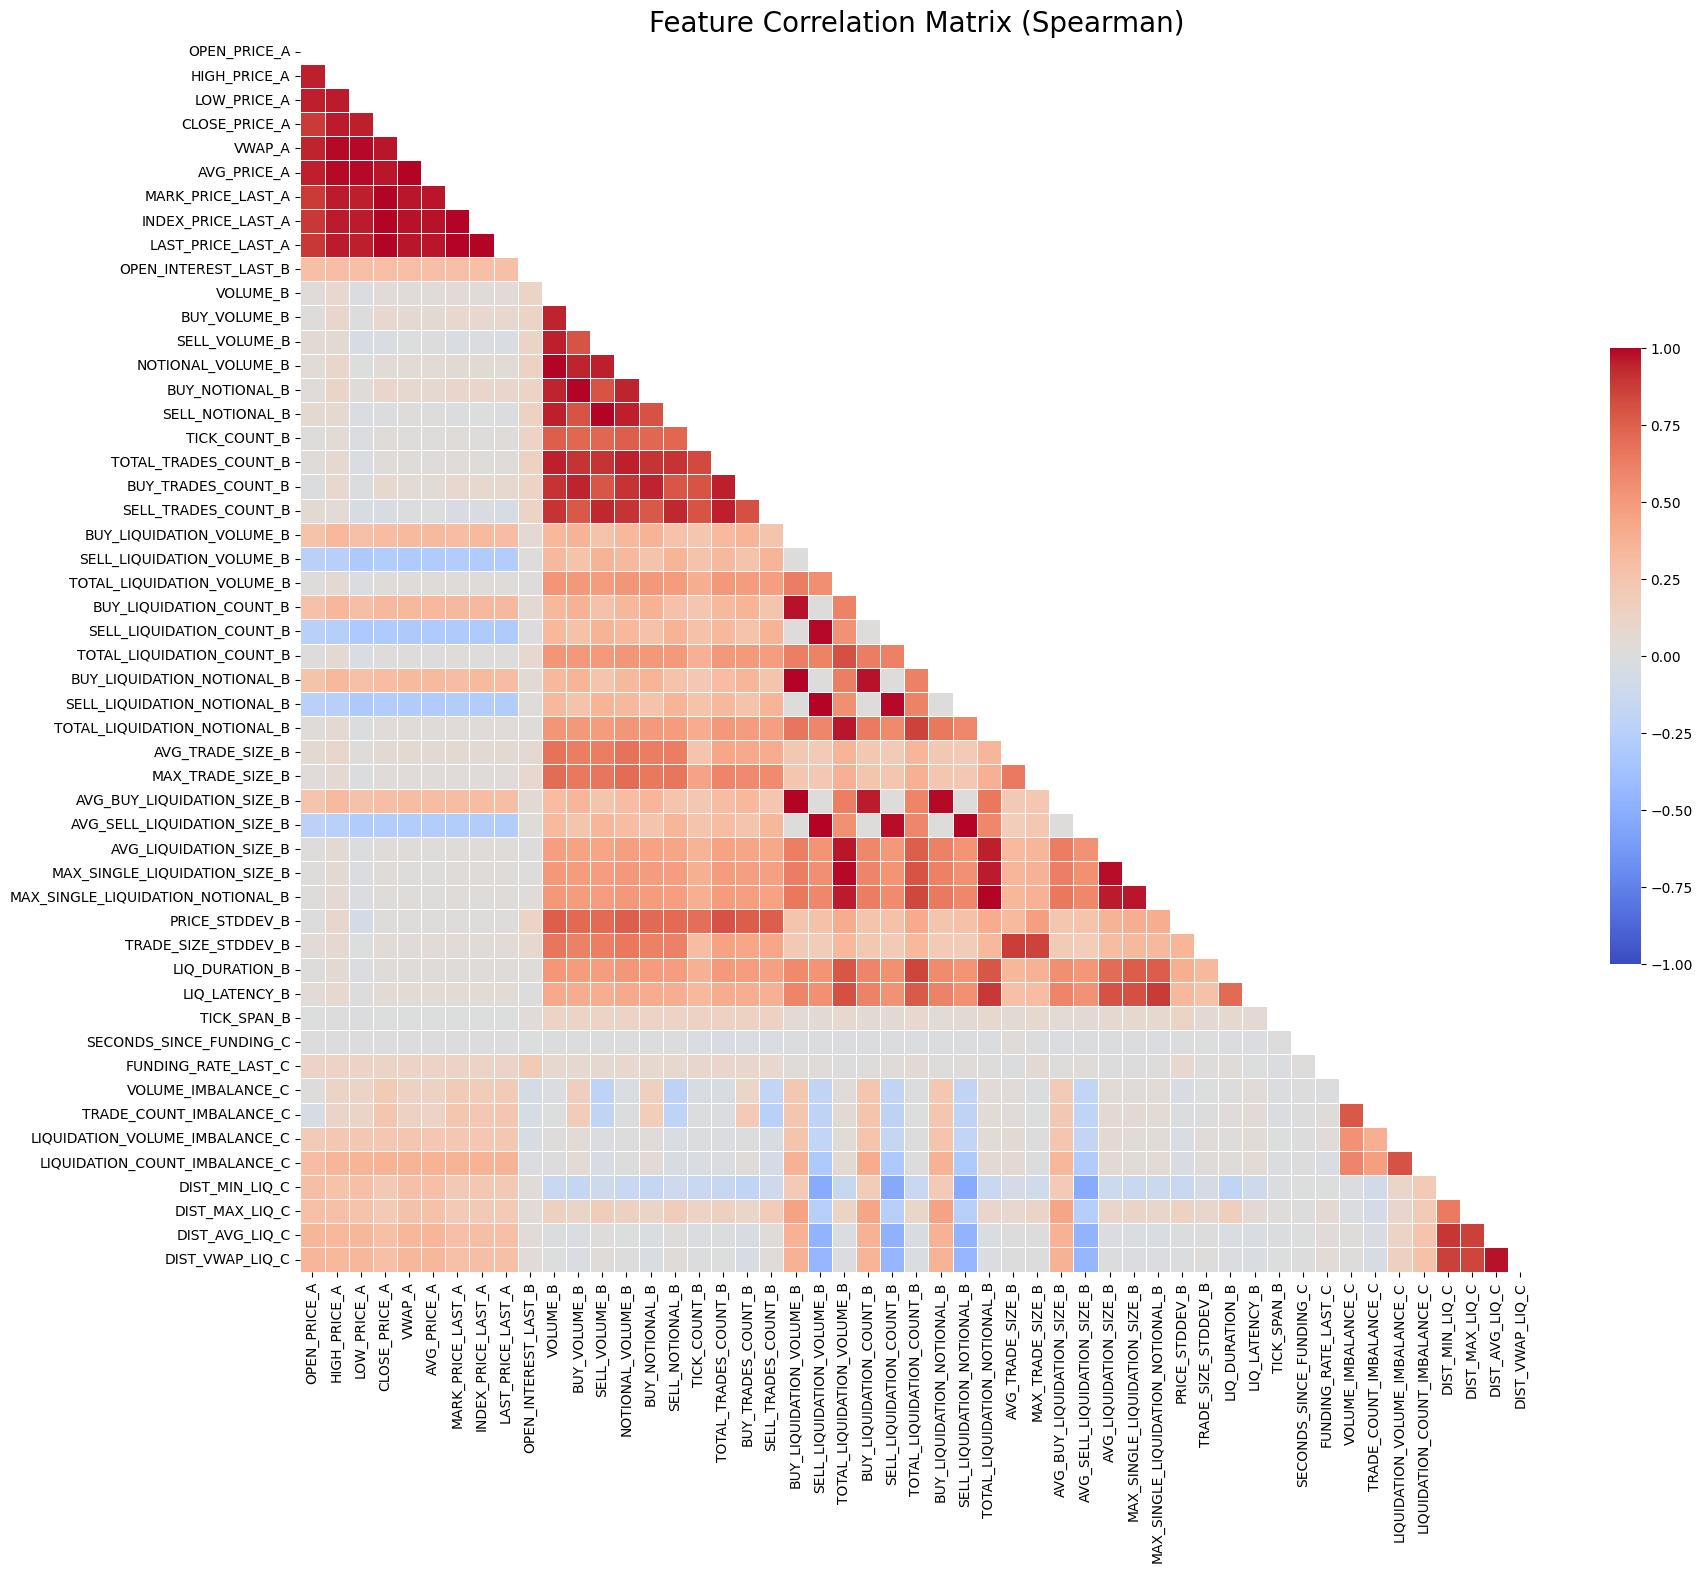


--- HIGHLY CORRELATED PAIRS (>0.95) ---


In [170]:
# ==========================================
# VISUAL ANALYSIS: CORRELATION HEATMAP
# ==========================================
def corr_heatmap(X) : 

    # 1. Select Numeric Columns
    numeric_df=  X

    # 2. Compute Correlation (Spearman)
    # Spearman is robust to outliers and captures monotonic relationships better than Pearson
    print("Computing Spearman Correlation Matrix...")
    corr_matrix = numeric_df.corr(method='spearman')

    # 3. Plotting
    plt.figure(figsize=(20, 16))

    # We use a mask to hide the upper triangle (it's symmetrical, so redundant)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Clustermap vs Heatmap
    # A standard heatmap is good, but a 'clustermap' automatically reorders 
    # columns to put similar features next to each other.
    # We'll use a standard heatmap first for raw inspection.
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        cmap='coolwarm',     # Red = High Positive, Blue = High Negative
        center=0,            # Center colormap at 0 correlation
        square=True, 
        linewidths=.5, 
        cbar_kws={"shrink": .5},
        vmin=-1, vmax=1      # Fix scale to -1 to 1
    )

    plt.title('Feature Correlation Matrix (Spearman)', fontsize=20)
    plt.yticks(rotation=0)
    plt.show()

    # 4. Numeric Output: Identify Top Collinear Pairs
    # This prints the pairs with correlation > 0.95 (Candidates for dropping)
    print("\n--- HIGHLY CORRELATED PAIRS (>0.95) ---")
    # Unstack the matrix to get pairs
    corr_pairs = corr_matrix.abs().unstack()
    # Filter self-correlations and duplicates
    corr_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)
    corr_pairs = corr_pairs[corr_pairs < 1.0] # Remove self correlation

    # Show top 20
    return corr_pairs

corr= corr_heatmap(X)

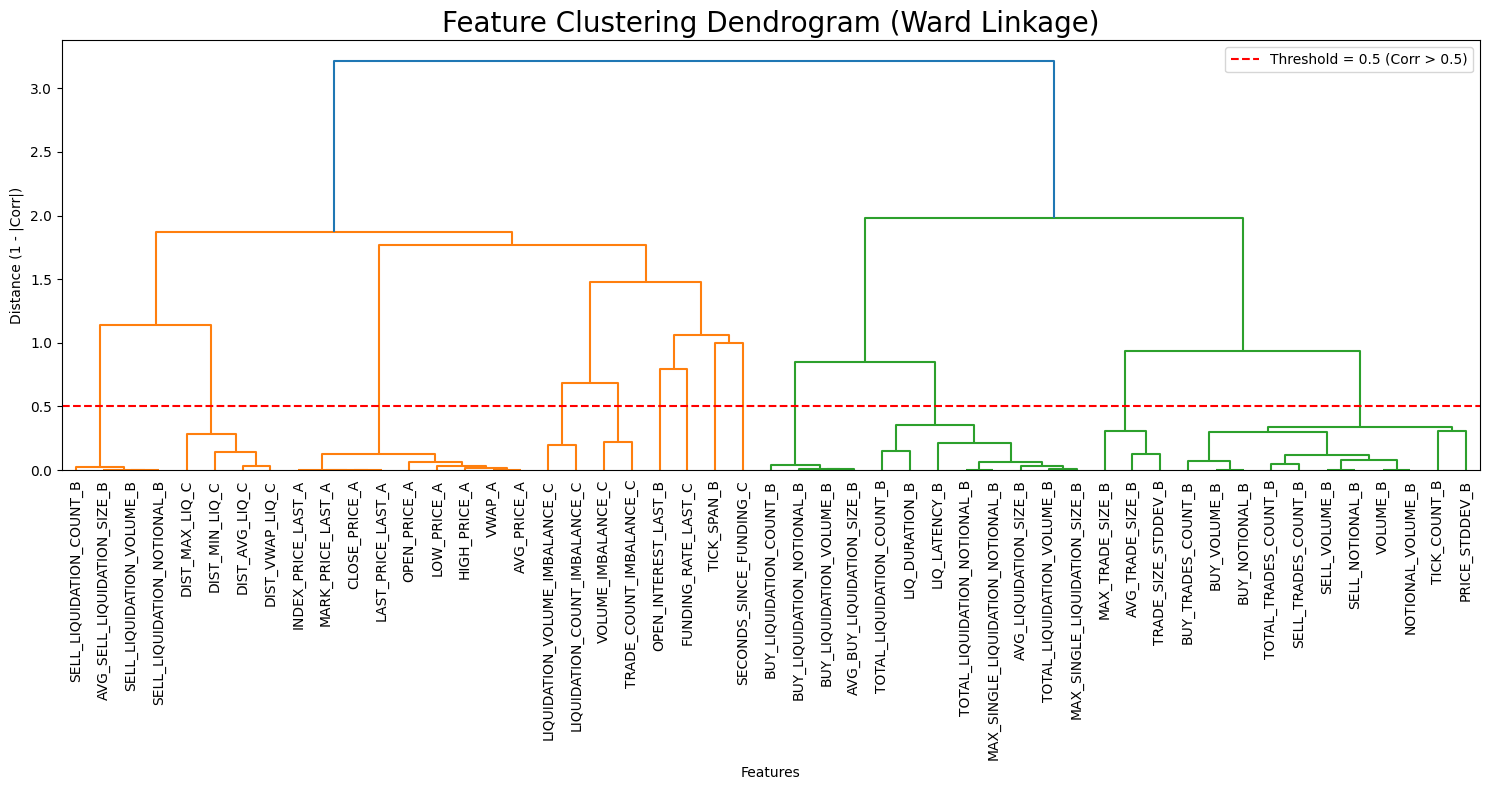

In [183]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

# ==========================================
# HIERARCHICAL CLUSTERING ANALYSIS
# ==========================================
def clustering_analysis(X, threshold=0.5, plot=True) : 
    # 2. Calculate Correlation Distance
    # We use Spearman (Rank) correlation
    corr = X.corr(method='spearman')

    # Convert correlation to "distance"
    # Distance is low (close) if correlation is high.
    # We use absolute correlation because -0.9 is just as strong a relationship as 0.9.
    distance_matrix = 1 - np.abs(corr)

    # 3. Perform Clustering (Linkage)
    # Ward's method minimizes the variance within clusters being merged.
    # It tends to create compact, even-sized clusters.
    # We use squareform to convert the matrix to the format scipy expects.
    
    linkage_matrix = sch.linkage(squareform(distance_matrix), method='ward')

    
    # 4. Plot Dendrogram
    if plot : 
        plt.figure(figsize=(15, 8))
        dendrogram = sch.dendrogram(
            linkage_matrix,
            labels=X.columns,
            leaf_rotation=90,
            leaf_font_size=10
        )
        plt.title('Feature Clustering Dendrogram (Ward Linkage)', fontsize=20)
        plt.xlabel('Features')
        plt.ylabel('Distance (1 - |Corr|)')
        plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold = 0.5 (Corr > 0.5)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return linkage_matrix

linkage_matrix= clustering_analysis(X)

In [172]:


# ==========================================
# FINAL CLUSTER ASSIGNMENT 
# ==========================================

def make_clusters(X, linkage_matrix, threshold=0.5, verbose = True):

    cluster_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')

    # 2. Create the Final Map
    feat_cluster_map = pd.DataFrame({
        'Feature': X.columns,
        'Cluster_ID': cluster_labels
    })

    # 3. Save/Print for Reference
    if verbose :
        print(f"--- FINAL CLUSTER CONFIGURATION (T={threshold}) ---")
        print(f"Total Clusters: {feat_cluster_map['Cluster_ID'].nunique()}")

    # Sort by cluster for easy reading
    feat_cluster_map = feat_cluster_map.sort_values('Cluster_ID')

    # Create a dictionary for quick lookups later {Feature: Cluster_ID}
    feature_to_cluster = dict(zip(feat_cluster_map['Feature'], feat_cluster_map['Cluster_ID']))

    # Show the breakdown
    if verbose:
        for cid in sorted(feat_cluster_map['Cluster_ID'].unique()):
            feats = feat_cluster_map[feat_cluster_map['Cluster_ID'] == cid]['Feature'].tolist()
            print(f"\nCluster {cid} ({len(feats)} features):")
            print(feats)
    return feature_to_cluster, feat_cluster_map

def align_data(df_final, targets, common_keys = ['BAR_TIMESTAMP', 'SYMBOL', 'EXCHANGE'], verbose = True):
    # ==============================================================================
    # STEP 1: ROBUST ALIGNMENT & CLEANUP
    # ==============================================================================
    if verbose :
        print("--- ALIGNING FEATURES AND TARGETS ---")

    # 1. Merge Features (df_final) and Targets on Metadata keys
    # This ensures we only keep rows where we have BOTH features AND labels.

    # Perform Inner Join
    df_aligned = pd.merge(
        df_final, 
        targets, 
        on=common_keys, 
        how='inner'
    )

    # 2. Separate X (Features) and Y (Targets)
    # Identify Target Columns (assuming they are the ones from the 'targets' df)
    target_cols = [c for c in targets.columns if c not in common_keys]
    feature_cols = [c for c in df_final.columns if c not in common_keys and c not in target_cols]

    X_full = df_aligned[feature_cols].copy()
    y_full = df_aligned[target_cols].copy()
    
    # 3. DROP NON-NUMERIC COLUMNS from X
    # Random Forest cannot handle 'SYMBOL' or 'EXCHANGE' strings.
    # We select only numeric types (float/int).
    X_numeric = X_full.select_dtypes(include=[np.number])

    # Sanity Check
    if verbose : 
        print(f"Aligned Rows: {len(X_numeric)}")
        print(f"Feature Count: {X_numeric.shape[1]} (Numeric Only)")
        print(f"Targets: {y_full.columns.tolist()}")
    
    return X_numeric, y_full

def verify_data(X_numeric, y_full, feature_to_cluster, verbose = True):
    # Ensure our 'feature_to_cluster' map doesn't contain columns we just dropped (strings)
    feature_to_cluster_clean = {k: v for k, v in feature_to_cluster.items() if k in X_numeric.columns}
    return feature_to_cluster_clean


# ==============================================================================
# ENGINE: ROBUST CLUSTERED MDA (WALK-FORWARD)
# ==============================================================================
def get_robust_clustered_mda(X, y, feature_to_cluster, n_splits=3, purge_size=24):
    """
    Args:
        purge_size: 24 (Matches your Triple Barrier Expiry)
    """
    # 1. Setup Model (Light RF)
    model_params = {'n_estimators': 150, 'max_depth': 5, 'n_jobs': -1, 'random_state': 42}
    
    # 2. Walk-Forward Splitter
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_scores = []
    
    print(f"Starting {n_splits}-Fold Walk-Forward MDA (Purge={purge_size})...")
    
    for fold_idx, (train_indices, val_indices) in enumerate(tscv.split(X)):
        
        # --- PURGING ---
        # Skip the first 'purge_size' rows of validation to prevent overlap leakage
        if len(val_indices) <= purge_size:
            continue
        val_indices = val_indices[purge_size:]
        
        # Split
        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]
        
        # Fit
        clf = RandomForestClassifier(**model_params)
        clf.fit(X_train, y_train)
        
        # Base Score (Log Loss)
        base_probs = clf.predict_proba(X_val)
        base_score = log_loss(y_val, base_probs, labels=clf.classes_)
        
        # --- CLUSTER PERMUTATION ---
        fold_importances = {}
        unique_clusters = sorted(list(set(feature_to_cluster.values())))
        
        for cid in unique_clusters:
            # Get features for this cluster that exist in X
            cluster_feats = [f for f, c in feature_to_cluster.items() if c == cid and f in X.columns]
            if not cluster_feats: continue
            
            # Shuffle
            X_val_shuffled = X_val.copy()
            shuffled_vals = X_val[cluster_feats].values.copy()
            np.random.shuffle(shuffled_vals)
            X_val_shuffled[cluster_feats] = shuffled_vals
            
            # Score Drop
            shuffled_probs = clf.predict_proba(X_val_shuffled)
            shuffled_score = log_loss(y_val, shuffled_probs, labels=clf.classes_)
            
            fold_importances[cid] = shuffled_score - base_score
            
        fold_scores.append(fold_importances)
        print(f"  Fold {fold_idx+1} Base Loss: {base_score:.4f}")

    # Aggregate
    return pd.DataFrame(fold_scores).mean().to_dict()


In [173]:

# ==============================================================================
# EXECUTION LOOP
# ==============================================================================
def run_pipeline(X_input, y_input, threshold = 0.5, n_splits=3, purge_size=24, verbose = True):
    
    X_num= X_input.select_dtypes(include=[np.number])
    linkage_matrix= clustering_analysis(X_num, plot = False)

    # use linkage_matrix to make clusters (make_clusters())
    feature_to_cluster, _ = make_clusters(X_num, linkage_matrix, threshold = threshold, verbose = verbose)

    # align data 
    X_numeric, y_full = align_data(X_input, y_input, verbose = verbose)
    
    # verify data
    feature_to_cluster_clean = verify_data(X_numeric, y_full, feature_to_cluster, verbose = verbose)

    mda_results = {}

    for target_col in y_full.columns:
        print(f"\n--- Processing Target: {target_col} ---")
        
        # Prepare Y (Drop NaNs)
        y_series = y_full[target_col]
        valid_mask = ~y_series.isna()
        
        # Filter X and Y to match valid targets
        X_clean = X_numeric[valid_mask]
        y_clean = y_series[valid_mask]
        
        # Run MDA
        # Note: purge_size=24 matches your expiry parameters
        scores = get_robust_clustered_mda(
            X_clean, 
            y_clean, 
            feature_to_cluster_clean, 
            n_splits=n_splits, 
            purge_size=purge_size
        )
        
        mda_results[target_col] = scores

    # ==============================================================================
    # FINAL REPORT
    # ==============================================================================
    df_mda = pd.DataFrame(mda_results)
    df_mda.index.name = "Cluster_ID"
    df_mda = df_mda.sort_index()
    if verbose :
        print("\n--- FINAL CLUSTER IMPORTANCE (Log Loss Decrease) ---")
        print(df_mda)

    # Check for "Dead" Clusters (Negative or Zero score across all targets)
    df_mda['Total_Importance'] = df_mda.sum(axis=1)
    dead_clusters = df_mda[df_mda['Total_Importance'] <= 0].index.tolist()


    return df_mda, dead_clusters

def visualize_cluster_importance(df_mda, dead_clusters):
    # ==============================================================================
    # VISUALIZE MDA RESULTS
    # ==============================================================================

    # 1. Setup the figure layout (2 plots: Heatmap & Bar Chart)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # --- PLOT A: HEATMAP (Target Specificity) ---
    # This shows exactly which cluster drives which target signal.
    sns.heatmap(
        df_mda.drop(columns=['Total_Importance'], errors='ignore'), # Exclude total if it exists
        annot=True,
        fmt=".4f",
        cmap="RdYlGn",   # Red = Bad (Negative), Green = Good (Positive)
        center=0,        # Center the color scale at 0 to highlight negative scores
        ax=axes[0],
        cbar_kws={'label': 'Log Loss Decrease (Higher is Better)'}
    )
    axes[0].set_title('Cluster Importance by Target', fontsize=15)
    axes[0].set_ylabel('Cluster ID')
    axes[0].set_xlabel('Target')

    # --- PLOT B: RANKED BAR CHART (Overall Power) ---
    # Calculate Total Importance across all targets to find the "MVPs"
    total_importance = df_mda.drop(columns=['Total_Importance'], errors='ignore').sum(axis=1).sort_values(ascending=True)

    # Color bars based on Positive (Green) or Negative (Red) impact
    colors = ['red' if x < 0 else 'forestgreen' for x in total_importance.values]

    total_importance.plot(kind='barh', ax=axes[1], color=colors, edgecolor='black')
    axes[1].axvline(0, color='black', linewidth=1) # Zero line
    axes[1].set_title('Overall Cluster Importance (Sum Across Targets)', fontsize=15)
    axes[1].set_xlabel('Cumulative Log Loss Decrease')

    plt.tight_layout()
    plt.show()

    # ==============================================================================
    # TEXT SUMMARY
    # ==============================================================================
    print("\n--- DECISION REPORT ---")
    # 1. Best Cluster
    best_cluster = total_importance.idxmax()
    print(f"🏆 MVP Cluster: Cluster {best_cluster} (Highest Total Signal)")

    # 2. Worst Clusters (Negative Impact)
    negative_clusters = total_importance[total_importance < 0].index.tolist()
    if negative_clusters:
        print(f"⚠️  Harmful Clusters (Negative Score - REMOVE THESE): {negative_clusters}")
    else:
        print("✅ No clusters were explicitly harmful (all > 0).")

    # 3. Useless Clusters (Near Zero)
    # Clusters that add less than 0.0001 total log loss improvement are basically noise.
    useless_clusters = total_importance[(total_importance >= 0) & (total_importance < 1e-4)].index.tolist()
    if useless_clusters:
        print(f"💤 Weak/Noise Clusters (Near Zero Impact): {useless_clusters}")



In [185]:
out = make_clusters(X, linkage_matrix, threshold = 0.3, verbose = True)

--- FINAL CLUSTER CONFIGURATION (T=0.3) ---
Total Clusters: 17

Cluster 1 (4 features):
['SELL_LIQUIDATION_COUNT_B', 'SELL_LIQUIDATION_NOTIONAL_B', 'SELL_LIQUIDATION_VOLUME_B', 'AVG_SELL_LIQUIDATION_SIZE_B']

Cluster 2 (4 features):
['DIST_MAX_LIQ_C', 'DIST_AVG_LIQ_C', 'DIST_MIN_LIQ_C', 'DIST_VWAP_LIQ_C']

Cluster 3 (9 features):
['LAST_PRICE_LAST_A', 'AVG_PRICE_A', 'MARK_PRICE_LAST_A', 'OPEN_PRICE_A', 'VWAP_A', 'HIGH_PRICE_A', 'LOW_PRICE_A', 'CLOSE_PRICE_A', 'INDEX_PRICE_LAST_A']

Cluster 4 (2 features):
['LIQUIDATION_VOLUME_IMBALANCE_C', 'LIQUIDATION_COUNT_IMBALANCE_C']

Cluster 5 (2 features):
['VOLUME_IMBALANCE_C', 'TRADE_COUNT_IMBALANCE_C']

Cluster 6 (1 features):
['OPEN_INTEREST_LAST_B']

Cluster 7 (1 features):
['FUNDING_RATE_LAST_C']

Cluster 8 (1 features):
['TICK_SPAN_B']

Cluster 9 (1 features):
['SECONDS_SINCE_FUNDING_C']

Cluster 10 (4 features):
['BUY_LIQUIDATION_VOLUME_B', 'BUY_LIQUIDATION_NOTIONAL_B', 'AVG_BUY_LIQUIDATION_SIZE_B', 'BUY_LIQUIDATION_COUNT_B']

Cluster 11

In [174]:
df_mda , dead_clusters = run_pipeline(df_final, targets, threshold = 0.5, verbose = True)

--- FINAL CLUSTER CONFIGURATION (T=0.5) ---
Total Clusters: 13

Cluster 1 (4 features):
['SELL_LIQUIDATION_COUNT_B', 'SELL_LIQUIDATION_NOTIONAL_B', 'SELL_LIQUIDATION_VOLUME_B', 'AVG_SELL_LIQUIDATION_SIZE_B']

Cluster 2 (4 features):
['DIST_MAX_LIQ_C', 'DIST_AVG_LIQ_C', 'DIST_MIN_LIQ_C', 'DIST_VWAP_LIQ_C']

Cluster 3 (9 features):
['LAST_PRICE_LAST_A', 'AVG_PRICE_A', 'MARK_PRICE_LAST_A', 'OPEN_PRICE_A', 'VWAP_A', 'HIGH_PRICE_A', 'LOW_PRICE_A', 'CLOSE_PRICE_A', 'INDEX_PRICE_LAST_A']

Cluster 4 (2 features):
['LIQUIDATION_VOLUME_IMBALANCE_C', 'LIQUIDATION_COUNT_IMBALANCE_C']

Cluster 5 (2 features):
['VOLUME_IMBALANCE_C', 'TRADE_COUNT_IMBALANCE_C']

Cluster 6 (1 features):
['OPEN_INTEREST_LAST_B']

Cluster 7 (1 features):
['FUNDING_RATE_LAST_C']

Cluster 8 (1 features):
['TICK_SPAN_B']

Cluster 9 (1 features):
['SECONDS_SINCE_FUNDING_C']

Cluster 10 (4 features):
['BUY_LIQUIDATION_VOLUME_B', 'BUY_LIQUIDATION_NOTIONAL_B', 'AVG_BUY_LIQUIDATION_SIZE_B', 'BUY_LIQUIDATION_COUNT_B']

Cluster 11

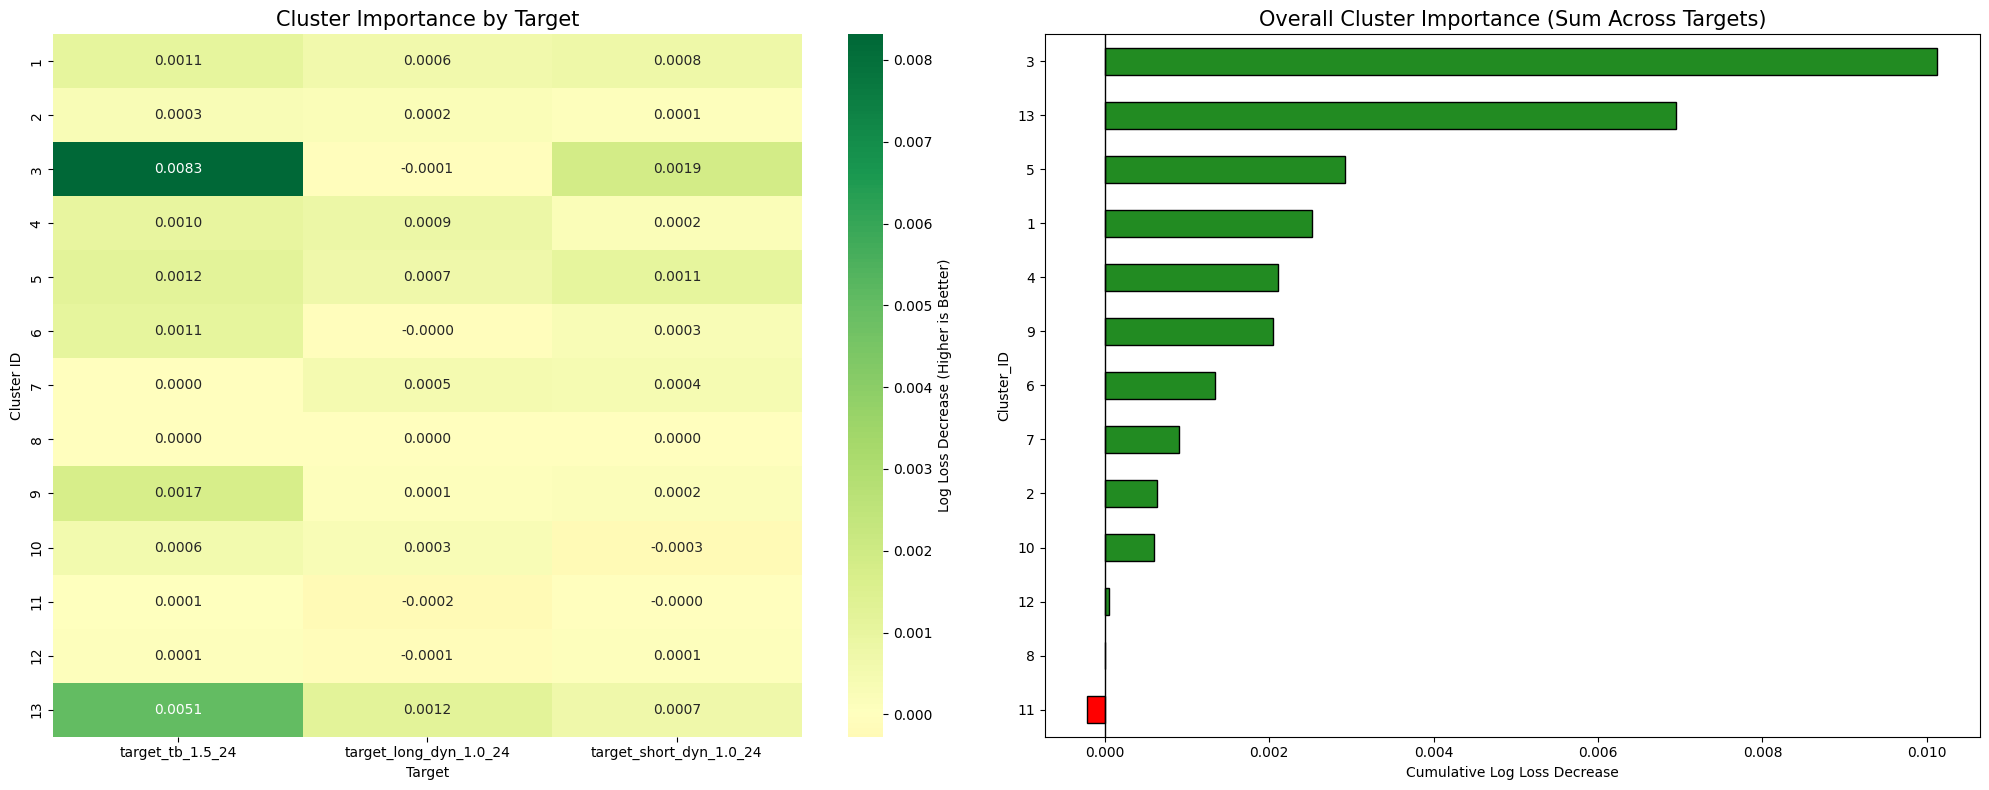


--- DECISION REPORT ---
🏆 MVP Cluster: Cluster 3 (Highest Total Signal)
⚠️  Harmful Clusters (Negative Score - REMOVE THESE): [11]
💤 Weak/Noise Clusters (Near Zero Impact): [8, 12]


In [175]:
visualize_cluster_importance(df_mda, dead_clusters)

In [176]:
df_mda , dead_clusters = run_pipeline(df_final, targets, threshold = 0.3, verbose = True)

--- FINAL CLUSTER CONFIGURATION (T=0.3) ---
Total Clusters: 17

Cluster 1 (4 features):
['SELL_LIQUIDATION_COUNT_B', 'SELL_LIQUIDATION_NOTIONAL_B', 'SELL_LIQUIDATION_VOLUME_B', 'AVG_SELL_LIQUIDATION_SIZE_B']

Cluster 2 (4 features):
['DIST_MAX_LIQ_C', 'DIST_AVG_LIQ_C', 'DIST_MIN_LIQ_C', 'DIST_VWAP_LIQ_C']

Cluster 3 (9 features):
['LAST_PRICE_LAST_A', 'AVG_PRICE_A', 'MARK_PRICE_LAST_A', 'OPEN_PRICE_A', 'VWAP_A', 'HIGH_PRICE_A', 'LOW_PRICE_A', 'CLOSE_PRICE_A', 'INDEX_PRICE_LAST_A']

Cluster 4 (2 features):
['LIQUIDATION_VOLUME_IMBALANCE_C', 'LIQUIDATION_COUNT_IMBALANCE_C']

Cluster 5 (2 features):
['VOLUME_IMBALANCE_C', 'TRADE_COUNT_IMBALANCE_C']

Cluster 6 (1 features):
['OPEN_INTEREST_LAST_B']

Cluster 7 (1 features):
['FUNDING_RATE_LAST_C']

Cluster 8 (1 features):
['TICK_SPAN_B']

Cluster 9 (1 features):
['SECONDS_SINCE_FUNDING_C']

Cluster 10 (4 features):
['BUY_LIQUIDATION_VOLUME_B', 'BUY_LIQUIDATION_NOTIONAL_B', 'AVG_BUY_LIQUIDATION_SIZE_B', 'BUY_LIQUIDATION_COUNT_B']

Cluster 11

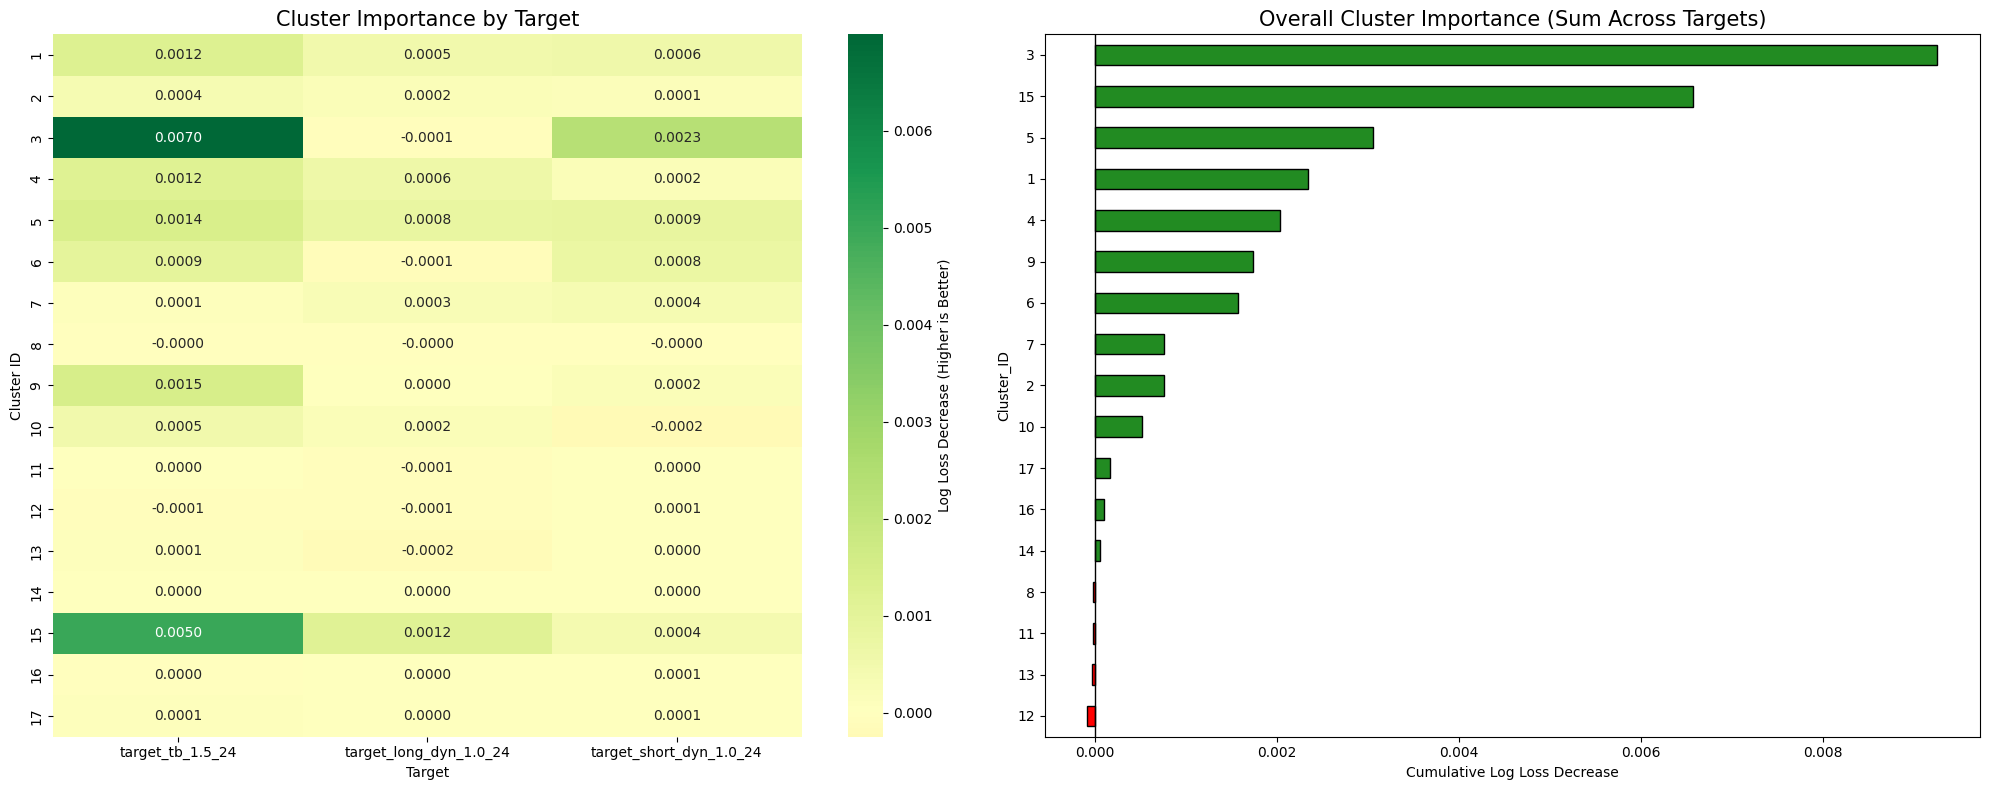


--- DECISION REPORT ---
🏆 MVP Cluster: Cluster 3 (Highest Total Signal)
⚠️  Harmful Clusters (Negative Score - REMOVE THESE): [12, 13, 11, 8]
💤 Weak/Noise Clusters (Near Zero Impact): [14, 16]


In [177]:
visualize_cluster_importance(df_mda, dead_clusters)

In [178]:
df_final.shape

(51544, 54)

In [180]:
df_agg = pd.read_csv("../results/final_feature_ranking_t0.3.csv")

In [181]:
df_agg.head()

,Feature,Global_Rank_Score,Long_Rank_Score,Short_Rank_Score,Raw_LogLoss_Sum
0,MARK_PRICE_LAST_A,0.020259,0.01965,0.019761,0.055549
1,CLOSE_PRICE_A,0.020259,0.01965,0.019761,0.055549
2,OPEN_PRICE_A,0.020259,0.01965,0.019761,0.055549
3,LOW_PRICE_A,0.020259,0.01965,0.019761,0.055549
4,LAST_PRICE_LAST_A,0.020259,0.01965,0.019761,0.055549


In [182]:
df_agg

,Feature,Global_Rank_Score,Long_Rank_Score,Short_Rank_Score,Raw_LogLoss_Sum
0,MARK_PRICE_LAST_A,0.020259,0.019650,0.019761,0.055549
1,CLOSE_PRICE_A,0.020259,0.019650,0.019761,0.055549
2,OPEN_PRICE_A,0.020259,0.019650,0.019761,0.055549
3,LOW_PRICE_A,0.020259,0.019650,0.019761,0.055549
4,LAST_PRICE_LAST_A,0.020259,0.019650,0.019761,0.055549
5,INDEX_PRICE_LAST_A,0.020259,0.019650,0.019761,0.055549
6,HIGH_PRICE_A,0.020259,0.019650,0.019761,0.055549
7,VWAP_A,0.020259,0.019650,0.019761,0.055549
8,AVG_PRICE_A,0.020259,0.019650,0.019761,0.055549
9,BUY_NOTIONAL_B,0.020110,0.019619,0.019632,0.048174


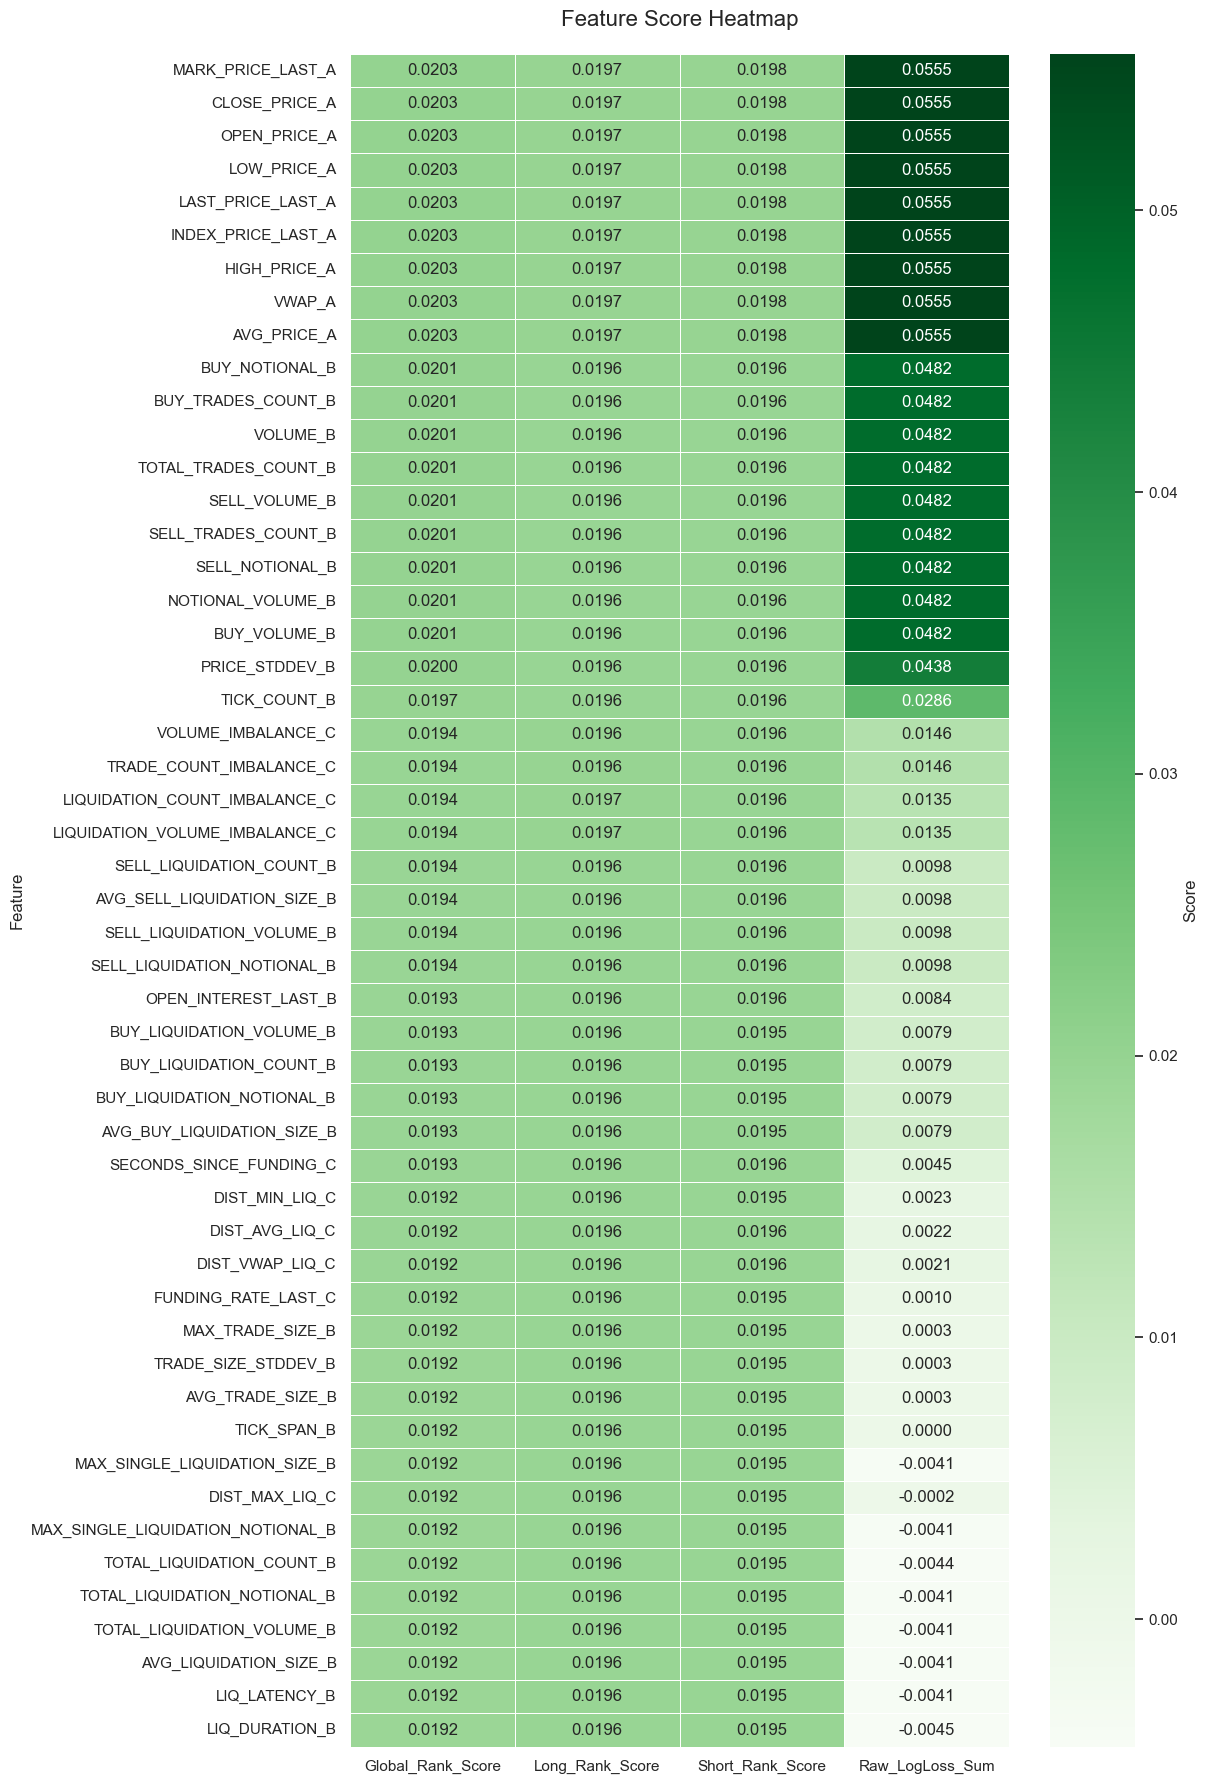

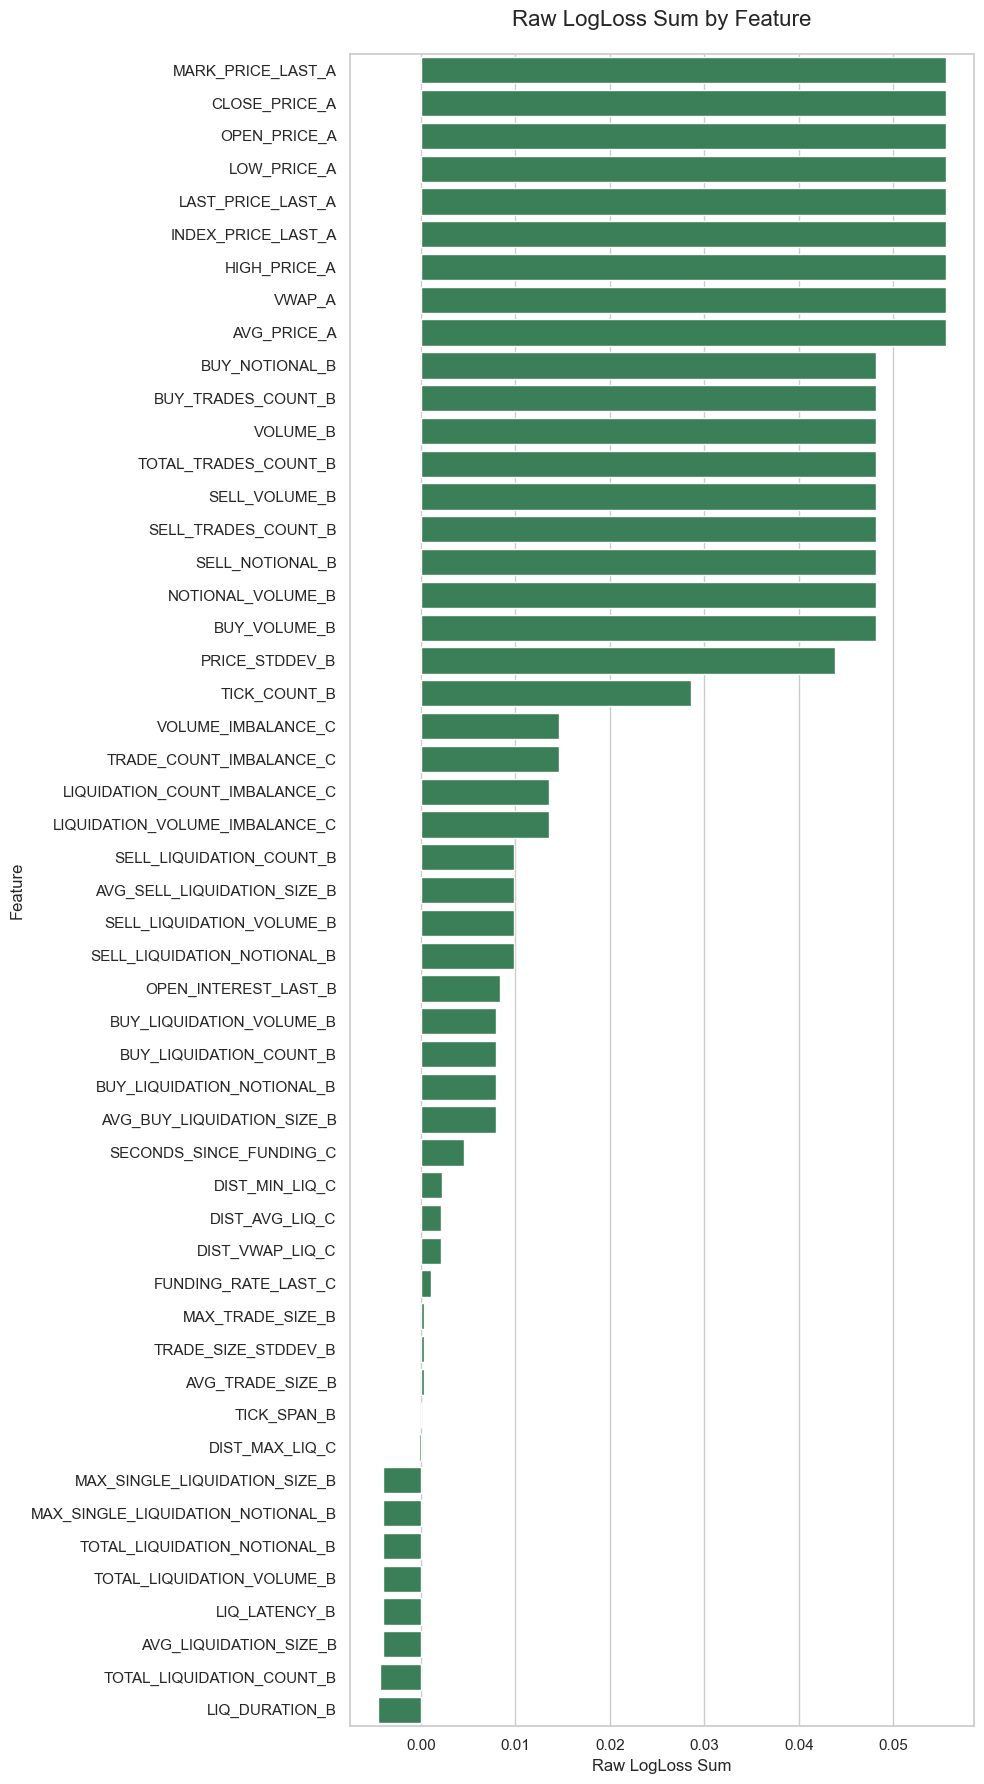

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style
sns.set_theme(style="whitegrid")

# --- 1. Heatmap ---
plt.figure(figsize=(12, 18))  # Tall figure for all features

# Set 'Feature' as index so it appears as y-axis labels
heatmap_data = df_agg.set_index('Feature')[['Global_Rank_Score', 'Long_Rank_Score', 'Short_Rank_Score', 'Raw_LogLoss_Sum']]

# Create Heatmap
sns.heatmap(
    heatmap_data, 
    annot=True,       # Show numbers
    fmt=".4f",        # 4 decimal places
    cmap="Greens",    # Use Green color scheme
    linewidths=.5, 
    cbar_kws={'label': 'Score'}
)

plt.title("Feature Score Heatmap", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# --- 2. Bar Plot (Raw_LogLoss_Sum) ---
plt.figure(figsize=(10, 18))

# Sort by Raw_LogLoss_Sum for a cleaner look (optional, remove sort_values if you want original order)
barplot_data = df_agg.sort_values("Raw_LogLoss_Sum", ascending=False)

sns.barplot(
    data=barplot_data,
    x="Raw_LogLoss_Sum",
    y="Feature",
    color="#2e8b57"  # "SeaGreen" hex code, or just use 'green'
)

plt.title("Raw LogLoss Sum by Feature", fontsize=16, pad=20)
plt.xlabel("Raw LogLoss Sum", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

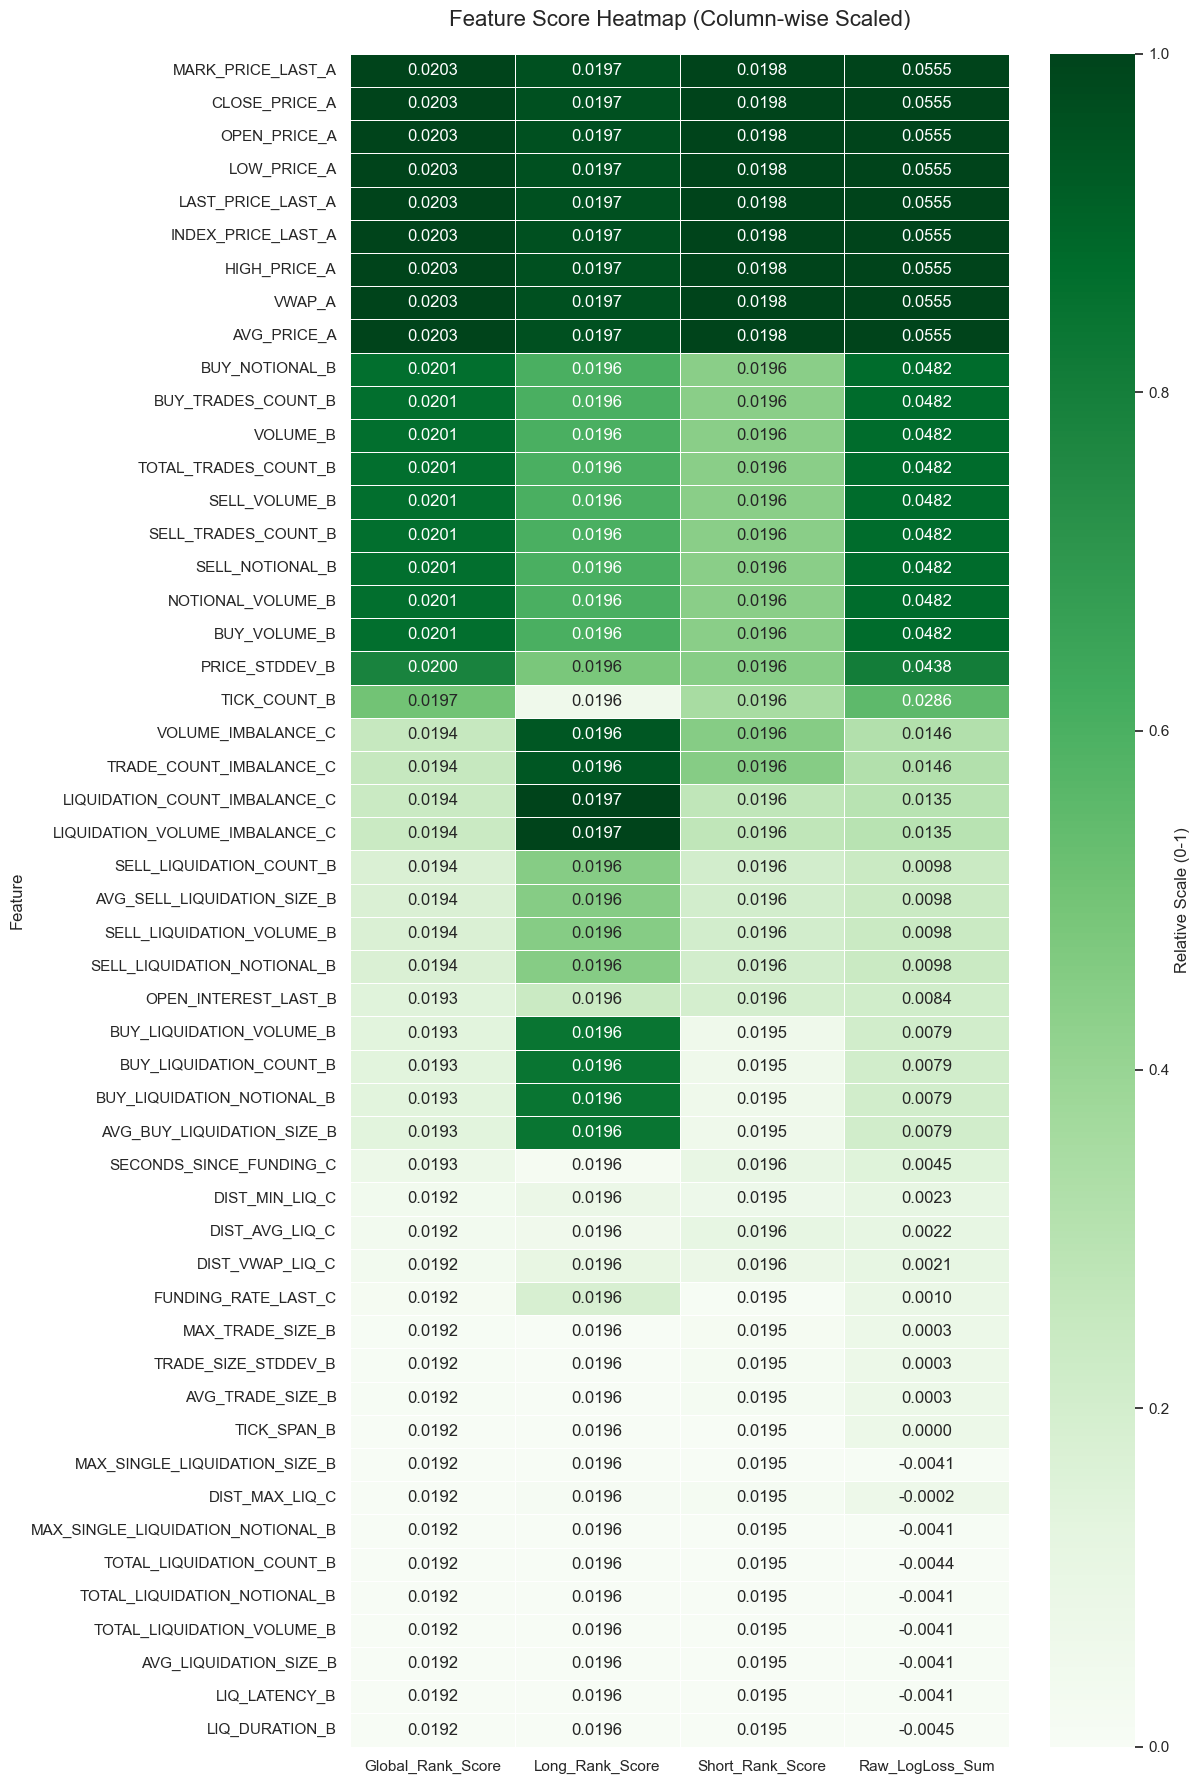

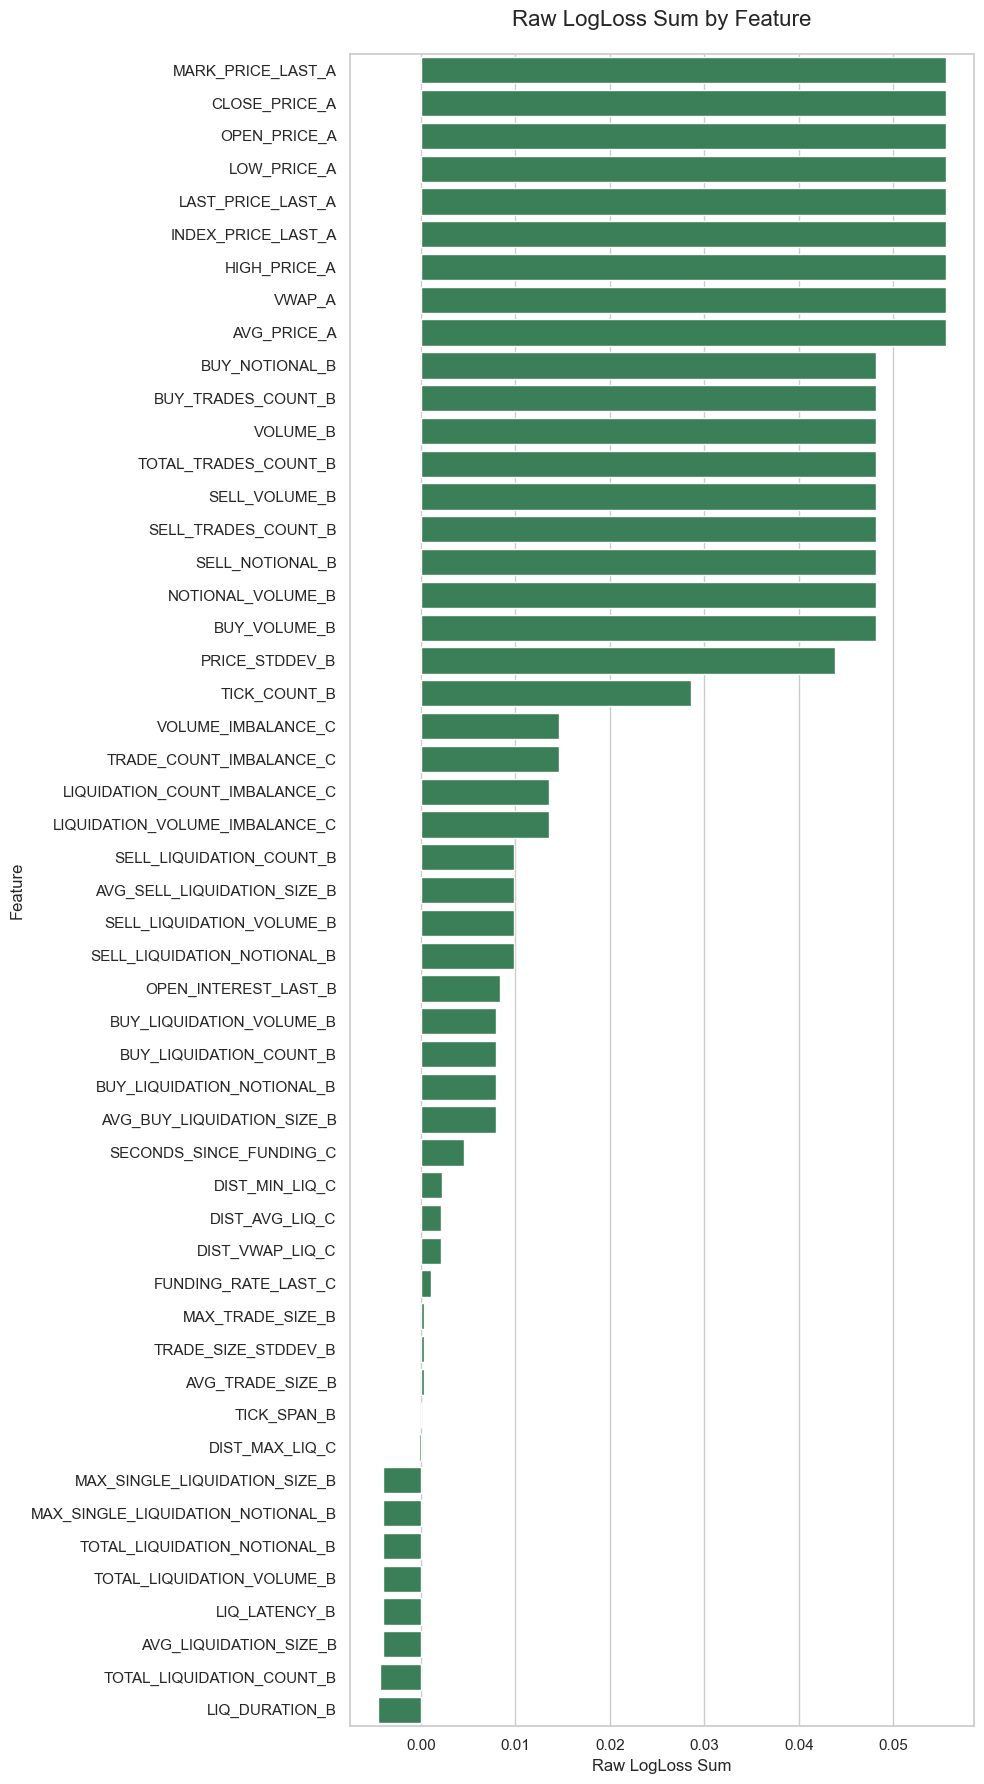

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Prepare Data for Heatmap
# Set 'Feature' as the index
heatmap_data = df_agg.set_index('Feature')[['Global_Rank_Score', 'Long_Rank_Score', 'Short_Rank_Score', 'Raw_LogLoss_Sum']]

# 2. Apply Column-wise Scaling (Min-Max Scaling)
# This makes every column range from 0 to 1, highlighting relative differences within that column.
heatmap_data_scaled = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())

# --- Plot 1: Scaled Heatmap ---
plt.figure(figsize=(12, 18))

sns.heatmap(
    heatmap_data_scaled, 
    annot=heatmap_data, # Use ORIGINAL values for the text numbers
    fmt=".4f",          # Format for the numbers
    cmap="Greens",      # Green color scheme
    linewidths=.5,
    cbar_kws={'label': 'Relative Scale (0-1)'}
)

plt.title("Feature Score Heatmap (Column-wise Scaled)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# --- Plot 2: Bar Plot (Raw_LogLoss_Sum) ---
# Same as before
plt.figure(figsize=(10, 18))

barplot_data = df_agg.sort_values("Raw_LogLoss_Sum", ascending=False)

sns.barplot(
    data=barplot_data,
    x="Raw_LogLoss_Sum",
    y="Feature",
    color="#2e8b57" # SeaGreen
)

plt.title("Raw LogLoss Sum by Feature", fontsize=16, pad=20)
plt.xlabel("Raw LogLoss Sum", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

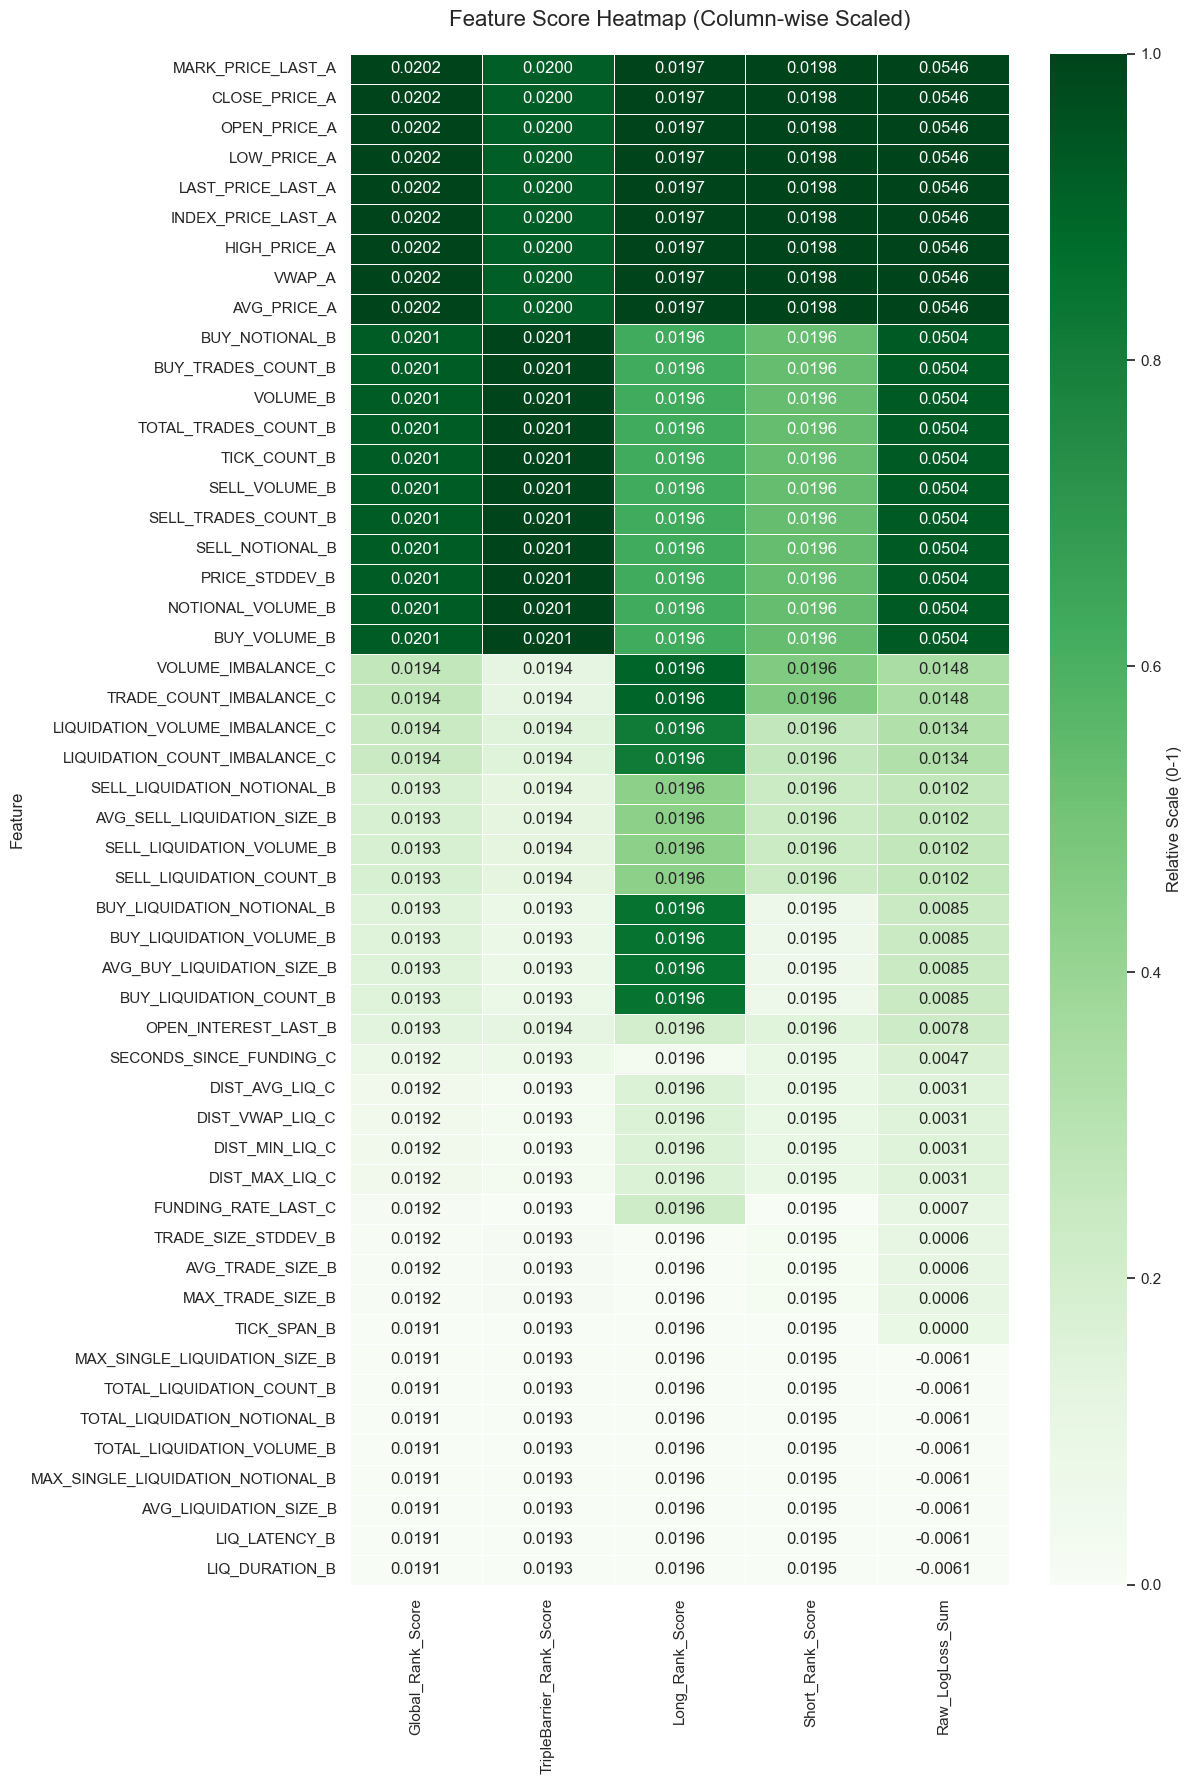

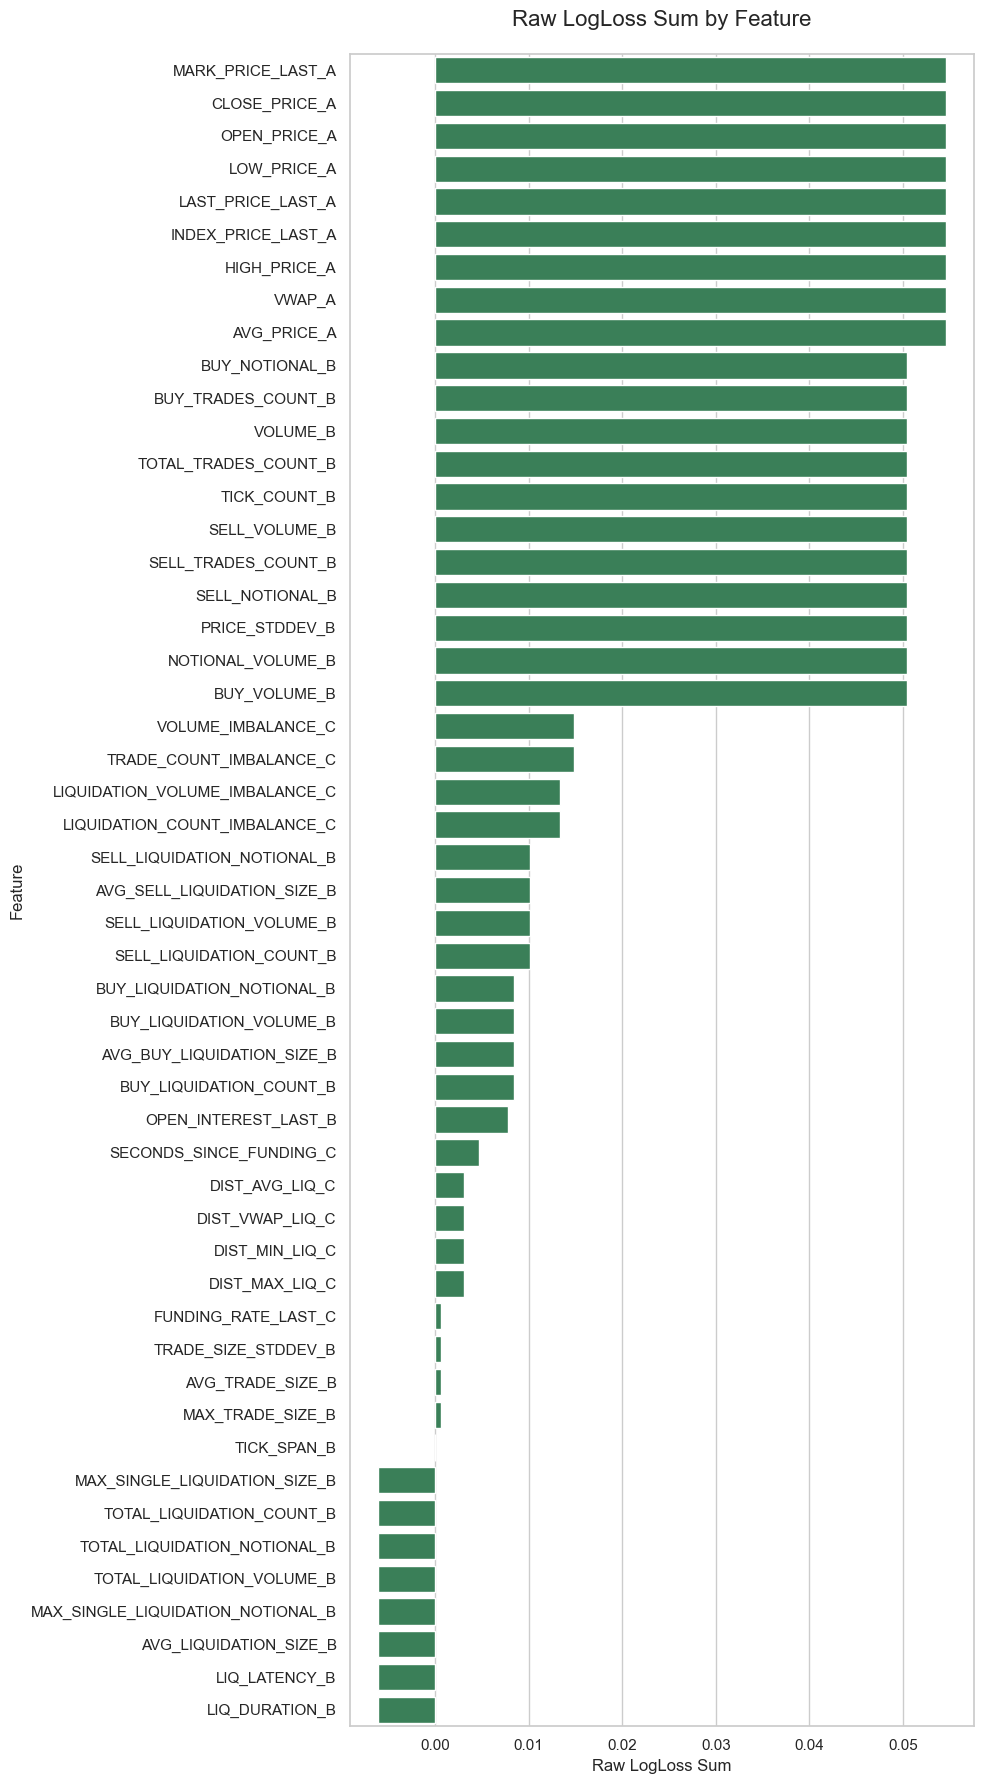

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df_agg = pd.read_csv("../results/final_feature_ranking_t0.5.csv")
# 1. Prepare Data for Heatmap
# Set 'Feature' as the index
heatmap_data = df_agg.set_index('Feature')[['Global_Rank_Score', 'TripleBarrier_Rank_Score', 'Long_Rank_Score', 'Short_Rank_Score', 'Raw_LogLoss_Sum']]

# 2. Apply Column-wise Scaling (Min-Max Scaling)
# This makes every column range from 0 to 1, highlighting relative differences within that column.
heatmap_data_scaled = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())

# --- Plot 1: Scaled Heatmap ---
plt.figure(figsize=(12, 18))

sns.heatmap(
    heatmap_data_scaled, 
    annot=heatmap_data, # Use ORIGINAL values for the text numbers
    fmt=".4f",          # Format for the numbers
    cmap="Greens",      # Green color scheme
    linewidths=.5,
    cbar_kws={'label': 'Relative Scale (0-1)'}
)

plt.title("Feature Score Heatmap (Column-wise Scaled)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# --- Plot 2: Bar Plot (Raw_LogLoss_Sum) ---
# Same as before
plt.figure(figsize=(10, 18))

barplot_data = df_agg.sort_values("Raw_LogLoss_Sum", ascending=False)

sns.barplot(
    data=barplot_data,
    x="Raw_LogLoss_Sum",
    y="Feature",
    color="#2e8b57" # SeaGreen
)

plt.title("Raw LogLoss Sum by Feature", fontsize=16, pad=20)
plt.xlabel("Raw LogLoss Sum", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

In [193]:
df_agg.head()

,Feature,Global_Rank_Score,Long_Rank_Score,Short_Rank_Score,TripleBarrier_Rank_Score,Raw_LogLoss_Sum
0,MARK_PRICE_LAST_A,0.020219,0.019655,0.019758,0.020019,0.054559
1,CLOSE_PRICE_A,0.020219,0.019655,0.019758,0.020019,0.054559
2,OPEN_PRICE_A,0.020219,0.019655,0.019758,0.020019,0.054559
3,LOW_PRICE_A,0.020219,0.019655,0.019758,0.020019,0.054559
4,LAST_PRICE_LAST_A,0.020219,0.019655,0.019758,0.020019,0.054559


In [194]:
df_agg

,Feature,Global_Rank_Score,Long_Rank_Score,Short_Rank_Score,TripleBarrier_Rank_Score,Raw_LogLoss_Sum
0,MARK_PRICE_LAST_A,0.020219,0.019655,0.019758,0.020019,0.054559
1,CLOSE_PRICE_A,0.020219,0.019655,0.019758,0.020019,0.054559
2,OPEN_PRICE_A,0.020219,0.019655,0.019758,0.020019,0.054559
3,LOW_PRICE_A,0.020219,0.019655,0.019758,0.020019,0.054559
4,LAST_PRICE_LAST_A,0.020219,0.019655,0.019758,0.020019,0.054559
5,INDEX_PRICE_LAST_A,0.020219,0.019655,0.019758,0.020019,0.054559
6,HIGH_PRICE_A,0.020219,0.019655,0.019758,0.020019,0.054559
7,VWAP_A,0.020219,0.019655,0.019758,0.020019,0.054559
8,AVG_PRICE_A,0.020219,0.019655,0.019758,0.020019,0.054559
9,BUY_NOTIONAL_B,0.020135,0.019620,0.019649,0.020083,0.050436
